In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import talos
from talos.utils import lr_normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import metrics
import keras.backend as K
from functools import partial

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [3]:
df = pd.read_csv('datasets/final_db.csv', index_col=0)
df.sort_index(inplace=True)
df.head(3)

,target,mean_sent,STOCH_slowk,STOCH_slowd,MACD,MACD_hist,CCI_5,CCI_10,CCI_21,CCI_50,MOM_5,MOM_10,MOM_21,RSI_5,RSI_10,RSI_21,RSI_50
Day,,,,,,,,,,,,,,,,,
2015-01-01,0.0,0.011820,67.198744,57.422805,-12.540186,4.426599,-76.487357,-58.930944,-57.963081,-8.626979,-28.059998,-48.588989,-80.842987,30.94113,30.495281,36.523877,43.526454
2015-01-02,1.0,0.009464,67.198744,57.422805,-12.540186,4.426599,-76.487357,-58.930944,-57.963081,-8.626979,-28.059998,-48.588989,-80.842987,30.94113,30.495281,36.523877,43.526454
2015-01-03,0.0,0.009646,67.198744,57.422805,-12.540186,4.426599,-76.487357,-58.930944,-57.963081,-8.626979,-28.059998,-48.588989,-80.842987,30.94113,30.495281,36.523877,43.526454


---
### Model and Functions

In [4]:
# Function to get class weights:
def cwts(data):
    c0, c1 = np.bincount(data['target'])
    #making the weights inversely proportional to the amount of observations:
    w0, w1 = (1/c0)*(len(data))/2, (1/c1)*(len(data))/2
    return {0: w0, 1:w1}

# Defining Recall, Precision, Specificity and F1 metrics:
#(https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05)
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

#========================================================================================#
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    #rampup epochs
    if epoch<=10:
        return lr
    return lr * tf.math.exp(-0.1*epoch)

#========================================================================================#
#LSTM ARCHITECTURE
def lstm_model(x_train, y_train, x_val, y_val, params):

    tf.keras.backend.clear_session()
    #This function defines the LSTM model
    win_length = params['window']
    batch_size = params['batch_size']
    num_features= x_train.shape[1]
    train_generator = TimeseriesGenerator(scaledtrain, y_train, length= win_length, sampling_rate = 1, batch_size= batch_size)
    test_generator = TimeseriesGenerator(scaledtest, y_val, length= win_length, sampling_rate = 1, batch_size= batch_size)
    #==================================================================#
    # MODEL ARCHITECTURE
    model = Sequential()
    #Input and first LSTM layer:
    model.add(LSTM(units=params['u1'], input_shape = (win_length, num_features), \
    return_sequences=True))
    # Dropout layer
    model.add(Dropout(params['dropout']))
    #Add second layer LSTM
    model.add(LSTM(units=params['u2'], return_sequences=False))
    #Dropout layer
    model.add(Dropout(params['dropout']))
    #Add a Dense layer
    model.add(Dense(params['dense_neurons'], activation = params['activation']))
    
    #Add the output layer – output layer
    model.add(Dense(1, activation = 'sigmoid'))#output layer

    #==================================================================#
    # Defining Early Stopping to avoid overfitting (after 3 attempts)
    early_stopping = EarlyStopping(monitor='val_loss',patience = 10, mode='min', restore_best_weights=True)

    # Using exponential decay:
    
    callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # Compiling
    # (lr=lr_normalizer(params['lr'], params['optimizer']))
    # callbacks = [early_stopping, callbacklr],
    model.compile(loss='binary_crossentropy', 
                    optimizer = params['optimizer'], 
                    metrics=['accuracy',precision,recall,f1,specificity,])
    
    history = model.fit(train_generator,
                        validation_data=test_generator, # validation sample with features
                        epochs = params['epochs'], # validation sample with labels
                        shuffle=False, callbacks = [early_stopping, callbacklr],#callbacklr
                        class_weight = class_weight, # imbalanced data
                        verbose=1
                        )

    return(history, model)

In [5]:
# We scale the data so hasten the LSTM's conversion
scaler = MinMaxScaler() 


# Features x Target

features = df.iloc[:,1:]
target = df.iloc[:,0]

# Shuffle is set to False because it is a timeseries, and the order matters.
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0, shuffle = False)

# Scaling
scaledtrain = scaler.fit_transform(x_train)
scaledtest = scaler.transform(x_test)

In [7]:
# Getting class weights to adjust accordingly during training
class_weight = cwts(df)
class_weight

{0: 1.1066666666666667, 1: 0.9120879120879121}

---
### Talos Hyperparameter Tuning

In [8]:

# Defining parameters considered in the hyperparameter tuning
params = {'lr': [1e-2,1e-3, 1e-4],
        'u1': [128,256], 
        'u2': [128,256], 
        'dropout': [0.3, 0.5],
        'batch_size': [32,64, 256], 
        'epochs': [100],
        'optimizer': ['Adam'],
        'activation': ['relu','elu'],
        'dense_neurons': [32, 64],
        'window': [21,50,200],
        }

# Scanning for best hyperparameters with Talos
scan = talos.Scan(x = x_train, y = y_train, x_val = x_test, y_val = y_test, params = params, model = lstm_model,experiment_name = 'lstm_model_val2', fraction_limit = 0.2)

  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/100
45/45 [==============================] - 10s 44ms/step - loss: 0.6965 - accuracy: 0.5248 - precision: 0.4812 - recall: 0.6016 - f1: 0.4866 - specificity: 0.4061 - val_loss: 0.7149 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 37ms/step - loss: 0.6923 - accuracy: 0.5220 - precision: 0.3947 - recall: 0.5656 - f1: 0.4394 - specificity: 0.4051 - val_loss: 0.7041 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 31ms/step - loss: 0.6919 - accuracy: 0.5248 - precision: 0.3412 - recall: 0.5135 - f1: 0.3942 - specificity: 0.4904 - val_loss: 0.6999 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 

  1%|          | 1/172 [00:56<2:41:43, 56.75s/it]

Epoch 1/100
23/23 [==============================] - 4s 67ms/step - loss: 0.6945 - accuracy: 0.5400 - precision: 0.5465 - recall: 0.6435 - f1: 0.5330 - specificity: 0.3726 - val_loss: 0.7033 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 36ms/step - loss: 0.7001 - accuracy: 0.5017 - precision: 0.4414 - recall: 0.4752 - f1: 0.3885 - specificity: 0.5177 - val_loss: 0.6984 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 30ms/step - loss: 0.6976 - accuracy: 0.4844 - precision: 0.4357 - recall: 0.4634 - f1: 0.3739 - specificity: 0.5285 - val_loss: 0.6916 - val_accuracy: 0.5217 - val_precision: 0.5134 - val_recall: 1.0000 - val_f1: 0.6744 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [========

  1%|          | 2/172 [01:17<1:40:33, 35.49s/it]

Epoch 1/100
23/23 [==============================] - 4s 65ms/step - loss: 0.6932 - accuracy: 0.5497 - precision: 0.4839 - recall: 0.6638 - f1: 0.5215 - specificity: 0.3352 - val_loss: 0.7215 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 37ms/step - loss: 0.6957 - accuracy: 0.5288 - precision: 0.4149 - recall: 0.6076 - f1: 0.4677 - specificity: 0.3867 - val_loss: 0.6983 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 28ms/step - loss: 0.6987 - accuracy: 0.5045 - precision: 0.4071 - recall: 0.5089 - f1: 0.3832 - specificity: 0.4957 - val_loss: 0.6912 - val_accuracy: 0.5188 - val_precision: 0.5111 - val_recall: 0.9821 - val_f1: 0.6688 - val_specificity: 0.0093 - lr: 0.0010
Epoch 4/100
23/23 [============

  2%|▏         | 3/172 [01:38<1:21:45, 29.03s/it]

Epoch 1/100
23/23 [==============================] - 5s 74ms/step - loss: 0.6972 - accuracy: 0.5227 - precision: 0.5567 - recall: 0.5369 - f1: 0.4950 - specificity: 0.4773 - val_loss: 0.6981 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 45ms/step - loss: 0.6978 - accuracy: 0.5113 - precision: 0.5605 - recall: 0.6059 - f1: 0.5186 - specificity: 0.3910 - val_loss: 0.6926 - val_accuracy: 0.5380 - val_precision: 0.5069 - val_recall: 0.5960 - val_f1: 0.5421 - val_specificity: 0.3809 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 38ms/step - loss: 0.6982 - accuracy: 0.4894 - precision: 0.5446 - recall: 0.5671 - f1: 0.4787 - specificity: 0.4463 - val_loss: 0.6929 - val_accuracy: 0.5253 - val_precision: 0.5156 - val_recall: 0.8125 - val_f1: 0.6276 - val_specificity: 0.1751 - lr: 0.0010
Epoch 4/100
23/23 [========================

  2%|▏         | 4/172 [02:03<1:16:46, 27.42s/it]

Epoch 1/100
6/6 [==============================] - 4s 225ms/step - loss: 0.6925 - accuracy: 0.5227 - precision: 0.5541 - recall: 0.6393 - f1: 0.5164 - specificity: 0.3501 - val_loss: 0.7007 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 106ms/step - loss: 0.6985 - accuracy: 0.4709 - precision: 0.4360 - recall: 0.4344 - f1: 0.3264 - specificity: 0.5660 - val_loss: 0.6910 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 97ms/step - loss: 0.6923 - accuracy: 0.5092 - precision: 0.5422 - recall: 0.6263 - f1: 0.5619 - specificity: 0.3526 - val_loss: 0.6918 - val_accuracy: 0.5633 - val_precision: 0.2966 - val_recall: 0.3094 - val_f1: 0.3028 - val_specificity: 0.7479 - lr: 0.0010
Epoch 4/100
6/6 [==========================

  3%|▎         | 5/172 [02:16<1:01:28, 22.09s/it]

Epoch 1/100
23/23 [==============================] - 5s 83ms/step - loss: 0.6970 - accuracy: 0.5448 - precision: 0.4553 - recall: 0.7081 - f1: 0.5358 - specificity: 0.2846 - val_loss: 0.7097 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 36ms/step - loss: 0.6945 - accuracy: 0.5323 - precision: 0.4236 - recall: 0.5210 - f1: 0.4075 - specificity: 0.4899 - val_loss: 0.7069 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 23ms/step - loss: 0.6948 - accuracy: 0.5254 - precision: 0.3946 - recall: 0.5979 - f1: 0.4538 - specificity: 0.4025 - val_loss: 0.6970 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

  3%|▎         | 6/172 [02:48<1:10:46, 25.58s/it]

Epoch 1/100
40/40 [==============================] - 6s 74ms/step - loss: 0.6935 - accuracy: 0.5365 - precision: 0.4348 - recall: 0.5806 - f1: 0.4697 - specificity: 0.4169 - val_loss: 0.6855 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6897 - accuracy: 0.5405 - precision: 0.4878 - recall: 0.5842 - f1: 0.4853 - specificity: 0.4229 - val_loss: 0.6838 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 47ms/step - loss: 0.6909 - accuracy: 0.5437 - precision: 0.4879 - recall: 0.6785 - f1: 0.5326 - specificity: 0.3113 - val_loss: 0.6857 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

  4%|▍         | 7/172 [03:19<1:15:25, 27.43s/it]

Epoch 1/100
20/20 [==============================] - 5s 96ms/step - loss: 0.7005 - accuracy: 0.5317 - precision: 0.5272 - recall: 0.7103 - f1: 0.5827 - specificity: 0.2974 - val_loss: 0.6873 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 61ms/step - loss: 0.6973 - accuracy: 0.5127 - precision: 0.5069 - recall: 0.6026 - f1: 0.4834 - specificity: 0.3864 - val_loss: 0.6921 - val_accuracy: 0.5361 - val_precision: 0.4137 - val_recall: 0.1043 - val_f1: 0.1609 - val_specificity: 0.8669 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 59ms/step - loss: 0.6967 - accuracy: 0.4976 - precision: 0.5343 - recall: 0.5540 - f1: 0.4497 - specificity: 0.4604 - val_loss: 0.7009 - val_accuracy: 0.4157 - val_precision: 0.4194 - val_recall: 0.8918 - val_f1: 0.5700 - val_specificity: 0.0498 - lr: 0.0010
Epoch 4/100
20/20 [========================

  5%|▍         | 8/172 [03:36<1:05:44, 24.05s/it]

Epoch 1/100
6/6 [==============================] - 4s 221ms/step - loss: 0.6939 - accuracy: 0.5156 - precision: 0.4663 - recall: 0.6587 - f1: 0.5229 - specificity: 0.3455 - val_loss: 0.6925 - val_accuracy: 0.5411 - val_precision: 0.5125 - val_recall: 0.5125 - val_f1: 0.5100 - val_specificity: 0.5372 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 86ms/step - loss: 0.6964 - accuracy: 0.4730 - precision: 0.6050 - recall: 0.4622 - f1: 0.4061 - specificity: 0.5418 - val_loss: 0.6912 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 41ms/step - loss: 0.6919 - accuracy: 0.5454 - precision: 0.5517 - recall: 0.8617 - f1: 0.6709 - specificity: 0.1371 - val_loss: 0.6913 - val_accuracy: 0.5222 - val_precision: 0.4790 - val_recall: 0.8931 - val_f1: 0.6232 - val_specificity: 0.0759 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 44

  5%|▌         | 9/172 [03:49<55:35, 20.46s/it]  

Epoch 1/100
5/5 [==============================] - 4s 339ms/step - loss: 0.7149 - accuracy: 0.4738 - precision: 0.5177 - recall: 0.6010 - f1: 0.4198 - specificity: 0.4000 - val_loss: 0.7224 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 78ms/step - loss: 0.6908 - accuracy: 0.5563 - precision: 0.5579 - recall: 0.9237 - f1: 0.6937 - specificity: 0.0633 - val_loss: 0.6917 - val_accuracy: 0.5542 - val_precision: 0.3750 - val_recall: 0.0417 - val_f1: 0.0750 - val_specificity: 0.9468 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 84ms/step - loss: 0.6910 - accuracy: 0.4929 - precision: 0.6308 - recall: 0.2502 - f1: 0.3419 - specificity: 0.8182 - val_loss: 0.6930 - val_accuracy: 0.5602 - val_precision: 0.4878 - val_recall: 0.2778 - val_f1: 0.3540 - val_specificity: 0.7766 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 10

  6%|▌         | 10/172 [04:12<57:44, 21.38s/it]

Epoch 1/100
45/45 [==============================] - 5s 45ms/step - loss: 0.6920 - accuracy: 0.5284 - precision: 0.4329 - recall: 0.6001 - f1: 0.4731 - specificity: 0.3909 - val_loss: 0.7119 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 47ms/step - loss: 0.6934 - accuracy: 0.5461 - precision: 0.5138 - recall: 0.6535 - f1: 0.5194 - specificity: 0.3584 - val_loss: 0.7057 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.6909 - accuracy: 0.5241 - precision: 0.3579 - recall: 0.5066 - f1: 0.3900 - specificity: 0.4921 - val_loss: 0.7058 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

  6%|▋         | 11/172 [04:59<1:18:38, 29.31s/it]

Epoch 1/100
20/20 [==============================] - 5s 99ms/step - loss: 0.7028 - accuracy: 0.5429 - precision: 0.5463 - recall: 0.7394 - f1: 0.5840 - specificity: 0.2716 - val_loss: 0.6874 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 2s 84ms/step - loss: 0.6964 - accuracy: 0.5111 - precision: 0.4812 - recall: 0.5961 - f1: 0.4660 - specificity: 0.4000 - val_loss: 0.6945 - val_accuracy: 0.4458 - val_precision: 0.4072 - val_recall: 0.5636 - val_f1: 0.4699 - val_specificity: 0.3537 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 51ms/step - loss: 0.6956 - accuracy: 0.5016 - precision: 0.5237 - recall: 0.6047 - f1: 0.4875 - specificity: 0.3930 - val_loss: 0.6990 - val_accuracy: 0.4157 - val_precision: 0.4206 - val_recall: 0.9041 - val_f1: 0.5735 - val_specificity: 0.0408 - lr: 0.0010
Epoch 4/100
20/20 [========================

  7%|▋         | 12/172 [05:16<1:08:05, 25.53s/it]

Epoch 1/100
6/6 [==============================] - 4s 206ms/step - loss: 0.7047 - accuracy: 0.4920 - precision: 0.4496 - recall: 0.5732 - f1: 0.4522 - specificity: 0.4306 - val_loss: 0.6914 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 36ms/step - loss: 0.6942 - accuracy: 0.4941 - precision: 0.5355 - recall: 0.4922 - f1: 0.4723 - specificity: 0.4998 - val_loss: 0.6944 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 64ms/step - loss: 0.6929 - accuracy: 0.4997 - precision: 0.5941 - recall: 0.3766 - f1: 0.4234 - specificity: 0.6724 - val_loss: 0.6918 - val_accuracy: 0.5217 - val_precision: 0.4930 - val_recall: 0.9744 - val_f1: 0.6536 - val_specificity: 0.0200 - lr: 0.0010
Epoch 4/100
6/6 [===========================

  8%|▊         | 13/172 [05:27<55:40, 21.01s/it]  

Epoch 1/100
5/5 [==============================] - 4s 288ms/step - loss: 0.7284 - accuracy: 0.4722 - precision: 0.3181 - recall: 0.5985 - f1: 0.4153 - specificity: 0.3995 - val_loss: 0.7295 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 150ms/step - loss: 0.6930 - accuracy: 0.5651 - precision: 0.5639 - recall: 0.9386 - f1: 0.7032 - specificity: 0.0668 - val_loss: 0.6916 - val_accuracy: 0.5602 - val_precision: 0.4444 - val_recall: 0.0556 - val_f1: 0.0988 - val_specificity: 0.9468 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 100ms/step - loss: 0.6927 - accuracy: 0.4698 - precision: 0.6954 - recall: 0.1677 - f1: 0.2403 - specificity: 0.8801 - val_loss: 0.6942 - val_accuracy: 0.4277 - val_precision: 0.3614 - val_recall: 0.4167 - val_f1: 0.3871 - val_specificity: 0.4362 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 

  8%|▊         | 14/172 [05:44<52:28, 19.93s/it]

Epoch 1/100
45/45 [==============================] - 5s 62ms/step - loss: 0.6993 - accuracy: 0.5262 - precision: 0.4456 - recall: 0.5937 - f1: 0.4763 - specificity: 0.4076 - val_loss: 0.7211 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 34ms/step - loss: 0.6930 - accuracy: 0.5319 - precision: 0.4478 - recall: 0.5637 - f1: 0.4579 - specificity: 0.4398 - val_loss: 0.7146 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 39ms/step - loss: 0.6923 - accuracy: 0.5298 - precision: 0.5265 - recall: 0.5587 - f1: 0.4598 - specificity: 0.4382 - val_loss: 0.7152 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

  9%|▊         | 15/172 [06:18<1:03:16, 24.18s/it]

Epoch 1/100
5/5 [==============================] - 3s 235ms/step - loss: 0.7270 - accuracy: 0.4794 - precision: 0.4515 - recall: 0.6075 - f1: 0.4499 - specificity: 0.3958 - val_loss: 0.7280 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 67ms/step - loss: 0.6914 - accuracy: 0.5508 - precision: 0.5829 - recall: 0.6609 - f1: 0.5633 - specificity: 0.3660 - val_loss: 0.6885 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 66ms/step - loss: 0.6941 - accuracy: 0.4381 - precision: 0.4860 - recall: 0.2189 - f1: 0.2494 - specificity: 0.7491 - val_loss: 0.6982 - val_accuracy: 0.4337 - val_precision: 0.4257 - val_recall: 0.8750 - val_f1: 0.5727 - val_specificity: 0.0957 - lr: 0.0010
Epoch 4/100
5/5 [===========================

  9%|▉         | 16/172 [06:26<50:09, 19.29s/it]  

Epoch 1/100
6/6 [==============================] - 4s 191ms/step - loss: 0.6926 - accuracy: 0.5319 - precision: 0.5524 - recall: 0.6228 - f1: 0.5503 - specificity: 0.3797 - val_loss: 0.7279 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 42ms/step - loss: 0.7034 - accuracy: 0.4752 - precision: 0.5312 - recall: 0.4028 - f1: 0.3465 - specificity: 0.6133 - val_loss: 0.6914 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 64ms/step - loss: 0.6926 - accuracy: 0.5596 - precision: 0.5577 - recall: 0.9395 - f1: 0.6991 - specificity: 0.0790 - val_loss: 0.6928 - val_accuracy: 0.5411 - val_precision: 0.5030 - val_recall: 0.8114 - val_f1: 0.6210 - val_specificity: 0.2344 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 10%|▉         | 17/172 [06:35<41:33, 16.09s/it]

Epoch 1/100
45/45 [==============================] - 4s 34ms/step - loss: 0.6943 - accuracy: 0.5305 - precision: 0.4250 - recall: 0.6051 - f1: 0.4652 - specificity: 0.3941 - val_loss: 0.7151 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6923 - accuracy: 0.5376 - precision: 0.4562 - recall: 0.5797 - f1: 0.4584 - specificity: 0.4222 - val_loss: 0.7134 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6908 - accuracy: 0.5411 - precision: 0.4255 - recall: 0.5935 - f1: 0.4646 - specificity: 0.4015 - val_loss: 0.7059 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 10%|█         | 18/172 [07:03<50:27, 19.66s/it]

Epoch 1/100
45/45 [==============================] - 4s 32ms/step - loss: 0.6937 - accuracy: 0.5518 - precision: 0.4890 - recall: 0.6696 - f1: 0.5245 - specificity: 0.3420 - val_loss: 0.7037 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5284 - precision: 0.4560 - recall: 0.6101 - f1: 0.4667 - specificity: 0.3750 - val_loss: 0.6978 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6934 - accuracy: 0.5376 - precision: 0.4283 - recall: 0.5747 - f1: 0.4574 - specificity: 0.4243 - val_loss: 0.6983 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 11%|█         | 19/172 [07:28<54:18, 21.30s/it]

Epoch 1/100
45/45 [==============================] - 4s 36ms/step - loss: 0.6972 - accuracy: 0.5177 - precision: 0.4350 - recall: 0.5718 - f1: 0.4673 - specificity: 0.4162 - val_loss: 0.7091 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6928 - accuracy: 0.5454 - precision: 0.5119 - recall: 0.5932 - f1: 0.4874 - specificity: 0.4211 - val_loss: 0.7191 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 19ms/step - loss: 0.6941 - accuracy: 0.5468 - precision: 0.4535 - recall: 0.6638 - f1: 0.5153 - specificity: 0.3428 - val_loss: 0.7015 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 12%|█▏        | 20/172 [07:58<1:00:06, 23.73s/it]

Epoch 1/100
6/6 [==============================] - 4s 211ms/step - loss: 0.7054 - accuracy: 0.4851 - precision: 0.4881 - recall: 0.5128 - f1: 0.3740 - specificity: 0.4769 - val_loss: 0.6909 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 48ms/step - loss: 0.6953 - accuracy: 0.4726 - precision: 0.5604 - recall: 0.5601 - f1: 0.4821 - specificity: 0.4321 - val_loss: 0.6914 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 51ms/step - loss: 0.6922 - accuracy: 0.5532 - precision: 0.5532 - recall: 0.9602 - f1: 0.6995 - specificity: 0.0482 - val_loss: 0.6913 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================]

 12%|█▏        | 21/172 [08:07<49:08, 19.53s/it]  

Epoch 1/100
40/40 [==============================] - 5s 60ms/step - loss: 0.6965 - accuracy: 0.5270 - precision: 0.4405 - recall: 0.6185 - f1: 0.4893 - specificity: 0.3782 - val_loss: 0.6839 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 3s 70ms/step - loss: 0.6901 - accuracy: 0.5524 - precision: 0.4698 - recall: 0.6976 - f1: 0.5346 - specificity: 0.2966 - val_loss: 0.6855 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 54ms/step - loss: 0.6919 - accuracy: 0.5563 - precision: 0.4604 - recall: 0.6910 - f1: 0.5281 - specificity: 0.3141 - val_loss: 0.6848 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 13%|█▎        | 22/172 [08:35<55:06, 22.04s/it]

Epoch 1/100
20/20 [==============================] - 5s 98ms/step - loss: 0.6939 - accuracy: 0.5548 - precision: 0.5057 - recall: 0.6943 - f1: 0.5266 - specificity: 0.3113 - val_loss: 0.6839 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 66ms/step - loss: 0.6929 - accuracy: 0.5278 - precision: 0.3719 - recall: 0.5538 - f1: 0.4215 - specificity: 0.4456 - val_loss: 0.6848 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 71ms/step - loss: 0.6945 - accuracy: 0.5302 - precision: 0.3971 - recall: 0.6333 - f1: 0.4797 - specificity: 0.3654 - val_loss: 0.6847 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 [

 13%|█▎        | 23/172 [08:53<51:49, 20.87s/it]

Epoch 1/100
23/23 [==============================] - 4s 64ms/step - loss: 0.6944 - accuracy: 0.5379 - precision: 0.4518 - recall: 0.6648 - f1: 0.5169 - specificity: 0.3154 - val_loss: 0.6958 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 40ms/step - loss: 0.6967 - accuracy: 0.4955 - precision: 0.3872 - recall: 0.3829 - f1: 0.3052 - specificity: 0.6247 - val_loss: 0.7122 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 0.6944 - accuracy: 0.5184 - precision: 0.3428 - recall: 0.4898 - f1: 0.3711 - specificity: 0.5022 - val_loss: 0.7241 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 14%|█▍        | 24/172 [09:14<51:40, 20.95s/it]

Epoch 1/100
6/6 [==============================] - 4s 191ms/step - loss: 0.7404 - accuracy: 0.4823 - precision: 0.3484 - recall: 0.6025 - f1: 0.4392 - specificity: 0.3865 - val_loss: 0.7010 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 40ms/step - loss: 0.6970 - accuracy: 0.5344 - precision: 0.5266 - recall: 0.6289 - f1: 0.5020 - specificity: 0.3768 - val_loss: 0.6968 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 101ms/step - loss: 0.6971 - accuracy: 0.4489 - precision: 0.3028 - recall: 0.0701 - f1: 0.0981 - specificity: 0.9391 - val_loss: 0.6908 - val_accuracy: 0.5449 - val_precision: 0.4938 - val_recall: 0.6077 - val_f1: 0.5251 - val_specificity: 0.4009 - lr: 0.0010
Epoch 4/100
6/6 [==========================

 15%|█▍        | 25/172 [09:26<44:16, 18.07s/it]

Epoch 1/100
5/5 [==============================] - 4s 370ms/step - loss: 0.6920 - accuracy: 0.5508 - precision: 0.5727 - recall: 0.6312 - f1: 0.5561 - specificity: 0.3914 - val_loss: 0.6902 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 153ms/step - loss: 0.7082 - accuracy: 0.4786 - precision: 0.4328 - recall: 0.4882 - f1: 0.3816 - specificity: 0.4988 - val_loss: 0.7130 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 144ms/step - loss: 0.6894 - accuracy: 0.5659 - precision: 0.5662 - recall: 0.9477 - f1: 0.7081 - specificity: 0.0644 - val_loss: 0.6934 - val_accuracy: 0.5120 - val_precision: 0.4384 - val_recall: 0.4444 - val_f1: 0.4414 - val_specificity: 0.5638 - lr: 0.0010
Epoch 4/100
5/5 [=========================

 15%|█▌        | 26/172 [09:53<50:31, 20.76s/it]

Epoch 1/100
45/45 [==============================] - 5s 51ms/step - loss: 0.6989 - accuracy: 0.5184 - precision: 0.4981 - recall: 0.5202 - f1: 0.4574 - specificity: 0.4813 - val_loss: 0.7077 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 41ms/step - loss: 0.6944 - accuracy: 0.5226 - precision: 0.5324 - recall: 0.5200 - f1: 0.4650 - specificity: 0.4927 - val_loss: 0.7088 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 41ms/step - loss: 0.6931 - accuracy: 0.5393 - precision: 0.4348 - recall: 0.5966 - f1: 0.4756 - specificity: 0.4037 - val_loss: 0.7312 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 16%|█▌        | 27/172 [10:44<1:12:06, 29.84s/it]

Epoch 1/100
5/5 [==============================] - 4s 384ms/step - loss: 0.6957 - accuracy: 0.5333 - precision: 0.5544 - recall: 0.7184 - f1: 0.6008 - specificity: 0.2605 - val_loss: 0.6837 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 325ms/step - loss: 0.7033 - accuracy: 0.4556 - precision: 0.6075 - recall: 0.3577 - f1: 0.2797 - specificity: 0.6417 - val_loss: 0.6993 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 182ms/step - loss: 0.6897 - accuracy: 0.5468 - precision: 0.5651 - recall: 0.8823 - f1: 0.6853 - specificity: 0.1260 - val_loss: 0.6962 - val_accuracy: 0.4458 - val_precision: 0.4324 - val_recall: 0.8889 - val_f1: 0.5818 - val_specificity: 0.1064 - lr: 0.0010
Epoch 4/100
5/5 [=========================

 16%|█▋        | 28/172 [10:59<1:01:21, 25.57s/it]

Epoch 1/100
6/6 [==============================] - 4s 300ms/step - loss: 0.6973 - accuracy: 0.5291 - precision: 0.4592 - recall: 0.6644 - f1: 0.5310 - specificity: 0.3396 - val_loss: 0.7052 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 43ms/step - loss: 0.7025 - accuracy: 0.4383 - precision: 0.1638 - recall: 0.2515 - f1: 0.1958 - specificity: 0.7376 - val_loss: 0.6907 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 103ms/step - loss: 0.6916 - accuracy: 0.5582 - precision: 0.5523 - recall: 0.9844 - f1: 0.7070 - specificity: 0.0140 - val_loss: 0.6907 - val_accuracy: 0.5253 - val_precision: 0.4796 - val_recall: 0.8546 - val_f1: 0.6144 - val_specificity: 0.1200 - lr: 0.0010
Epoch 4/100
6/6 [==========================

 17%|█▋        | 29/172 [11:11<50:38, 21.25s/it]  

Epoch 1/100
6/6 [==============================] - 4s 193ms/step - loss: 0.6998 - accuracy: 0.4885 - precision: 0.6195 - recall: 0.5272 - f1: 0.4113 - specificity: 0.4594 - val_loss: 0.6921 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 38ms/step - loss: 0.6943 - accuracy: 0.5136 - precision: 0.5535 - recall: 0.6187 - f1: 0.5646 - specificity: 0.3899 - val_loss: 0.6927 - val_accuracy: 0.5478 - val_precision: 0.5278 - val_recall: 0.3571 - val_f1: 0.4037 - val_specificity: 0.6952 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 37ms/step - loss: 0.6936 - accuracy: 0.4871 - precision: 0.5783 - recall: 0.3527 - f1: 0.4211 - specificity: 0.6730 - val_loss: 0.6913 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0

 17%|█▋        | 30/172 [11:22<43:20, 18.31s/it]

Epoch 1/100
45/45 [==============================] - 7s 96ms/step - loss: 0.7042 - accuracy: 0.5078 - precision: 0.5091 - recall: 0.5147 - f1: 0.4534 - specificity: 0.4916 - val_loss: 0.7178 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 48ms/step - loss: 0.6964 - accuracy: 0.5234 - precision: 0.5389 - recall: 0.5488 - f1: 0.4802 - specificity: 0.4455 - val_loss: 0.7196 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 38ms/step - loss: 0.6937 - accuracy: 0.5298 - precision: 0.5228 - recall: 0.5992 - f1: 0.5050 - specificity: 0.3754 - val_loss: 0.7075 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 18%|█▊        | 31/172 [12:21<1:11:54, 30.60s/it]

Epoch 1/100
5/5 [==============================] - 4s 328ms/step - loss: 0.6990 - accuracy: 0.5103 - precision: 0.5736 - recall: 0.6629 - f1: 0.5402 - specificity: 0.3392 - val_loss: 0.6986 - val_accuracy: 0.4458 - val_precision: 0.4324 - val_recall: 0.8889 - val_f1: 0.5818 - val_specificity: 0.1064 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 96ms/step - loss: 0.6908 - accuracy: 0.5254 - precision: 0.6018 - recall: 0.5459 - f1: 0.5512 - specificity: 0.5254 - val_loss: 0.6959 - val_accuracy: 0.4398 - val_precision: 0.4054 - val_recall: 0.6250 - val_f1: 0.4918 - val_specificity: 0.2979 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 162ms/step - loss: 0.6874 - accuracy: 0.5516 - precision: 0.5697 - recall: 0.8079 - f1: 0.6669 - specificity: 0.2148 - val_loss: 0.6977 - val_accuracy: 0.4639 - val_precision: 0.4320 - val_recall: 0.7500 - val_f1: 0.5482 - val_specificity: 0.2447 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 1s 197ms

 19%|█▊        | 32/172 [12:38<1:01:51, 26.51s/it]

Epoch 1/100
20/20 [==============================] - 5s 111ms/step - loss: 0.6887 - accuracy: 0.5492 - precision: 0.5700 - recall: 0.6606 - f1: 0.5596 - specificity: 0.3698 - val_loss: 0.6908 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 75ms/step - loss: 0.6982 - accuracy: 0.5325 - precision: 0.5650 - recall: 0.6219 - f1: 0.5088 - specificity: 0.3773 - val_loss: 0.6846 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 53ms/step - loss: 0.6967 - accuracy: 0.5262 - precision: 0.5317 - recall: 0.5825 - f1: 0.4668 - specificity: 0.4378 - val_loss: 0.6887 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 

 19%|█▉        | 33/172 [13:00<57:56, 25.01s/it]  

Epoch 1/100
23/23 [==============================] - 5s 94ms/step - loss: 0.6949 - accuracy: 0.5365 - precision: 0.4719 - recall: 0.6979 - f1: 0.5360 - specificity: 0.3023 - val_loss: 0.6929 - val_accuracy: 0.5391 - val_precision: 0.5177 - val_recall: 0.9206 - val_f1: 0.6608 - val_specificity: 0.0917 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 32ms/step - loss: 0.6951 - accuracy: 0.5254 - precision: 0.4825 - recall: 0.5902 - f1: 0.4811 - specificity: 0.4192 - val_loss: 0.6948 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 25ms/step - loss: 0.6939 - accuracy: 0.4767 - precision: 0.3738 - recall: 0.4489 - f1: 0.3473 - specificity: 0.5350 - val_loss: 0.6921 - val_accuracy: 0.5217 - val_precision: 0.5134 - val_recall: 1.0000 - val_f1: 0.6744 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [====================

 20%|█▉        | 34/172 [13:21<54:44, 23.80s/it]

Epoch 1/100
23/23 [==============================] - 5s 86ms/step - loss: 0.6940 - accuracy: 0.5270 - precision: 0.4310 - recall: 0.6019 - f1: 0.4622 - specificity: 0.3745 - val_loss: 0.7260 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 55ms/step - loss: 0.6917 - accuracy: 0.5326 - precision: 0.3813 - recall: 0.5247 - f1: 0.4146 - specificity: 0.4654 - val_loss: 0.7096 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 46ms/step - loss: 0.6941 - accuracy: 0.5489 - precision: 0.4553 - recall: 0.6796 - f1: 0.5217 - specificity: 0.3309 - val_loss: 0.6979 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 20%|██        | 35/172 [14:01<1:05:24, 28.64s/it]

Epoch 1/100
23/23 [==============================] - 5s 97ms/step - loss: 0.6953 - accuracy: 0.5411 - precision: 0.4951 - recall: 0.6396 - f1: 0.5273 - specificity: 0.3728 - val_loss: 0.7273 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 50ms/step - loss: 0.6928 - accuracy: 0.5348 - precision: 0.4258 - recall: 0.5577 - f1: 0.4441 - specificity: 0.4464 - val_loss: 0.7149 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 0.6944 - accuracy: 0.5262 - precision: 0.4086 - recall: 0.5522 - f1: 0.4265 - specificity: 0.4528 - val_loss: 0.7019 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 21%|██        | 36/172 [14:30<1:05:35, 28.94s/it]

Epoch 1/100
6/6 [==============================] - 4s 176ms/step - loss: 0.7282 - accuracy: 0.4851 - precision: 0.4351 - recall: 0.5728 - f1: 0.4355 - specificity: 0.4200 - val_loss: 0.6970 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 92ms/step - loss: 0.6968 - accuracy: 0.5101 - precision: 0.5140 - recall: 0.5724 - f1: 0.4924 - specificity: 0.4088 - val_loss: 0.6962 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 52ms/step - loss: 0.6944 - accuracy: 0.4649 - precision: 0.5620 - recall: 0.2093 - f1: 0.2552 - specificity: 0.8108 - val_loss: 0.6908 - val_accuracy: 0.5188 - val_precision: 0.4926 - val_recall: 0.8854 - val_f1: 0.6329 - val_specificity: 0.1074 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 22%|██▏       | 37/172 [14:40<52:20, 23.26s/it]  

Epoch 1/100
40/40 [==============================] - 6s 78ms/step - loss: 0.6987 - accuracy: 0.5183 - precision: 0.5103 - recall: 0.5300 - f1: 0.4620 - specificity: 0.4606 - val_loss: 0.6850 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 53ms/step - loss: 0.6921 - accuracy: 0.5429 - precision: 0.5280 - recall: 0.6166 - f1: 0.5002 - specificity: 0.3915 - val_loss: 0.6842 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 63ms/step - loss: 0.6894 - accuracy: 0.5365 - precision: 0.5115 - recall: 0.5457 - f1: 0.4818 - specificity: 0.4849 - val_loss: 0.6851 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 22%|██▏       | 38/172 [15:13<58:13, 26.07s/it]

Epoch 1/100
45/45 [==============================] - 5s 47ms/step - loss: 0.6974 - accuracy: 0.5199 - precision: 0.5001 - recall: 0.5834 - f1: 0.4771 - specificity: 0.4132 - val_loss: 0.7230 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 47ms/step - loss: 0.6965 - accuracy: 0.5383 - precision: 0.4893 - recall: 0.6470 - f1: 0.5265 - specificity: 0.3695 - val_loss: 0.7082 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 38ms/step - loss: 0.6925 - accuracy: 0.5426 - precision: 0.4224 - recall: 0.5978 - f1: 0.4661 - specificity: 0.4085 - val_loss: 0.7096 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 23%|██▎       | 39/172 [16:08<1:17:16, 34.86s/it]

Epoch 1/100
23/23 [==============================] - 4s 65ms/step - loss: 0.6939 - accuracy: 0.5241 - precision: 0.4187 - recall: 0.5712 - f1: 0.4483 - specificity: 0.4106 - val_loss: 0.7061 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 31ms/step - loss: 0.6929 - accuracy: 0.5319 - precision: 0.4055 - recall: 0.5973 - f1: 0.4610 - specificity: 0.4110 - val_loss: 0.7015 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 30ms/step - loss: 0.6957 - accuracy: 0.5050 - precision: 0.3425 - recall: 0.5444 - f1: 0.4059 - specificity: 0.4487 - val_loss: 0.6916 - val_accuracy: 0.5222 - val_precision: 0.5210 - val_recall: 1.0000 - val_f1: 0.6796 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [========

 23%|██▎       | 40/172 [16:27<1:06:04, 30.03s/it]

Epoch 1/100
45/45 [==============================] - 6s 67ms/step - loss: 0.7029 - accuracy: 0.4972 - precision: 0.5024 - recall: 0.5528 - f1: 0.4738 - specificity: 0.4096 - val_loss: 0.7075 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 32ms/step - loss: 0.6965 - accuracy: 0.5312 - precision: 0.5160 - recall: 0.6000 - f1: 0.5109 - specificity: 0.4054 - val_loss: 0.7106 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 31ms/step - loss: 0.6924 - accuracy: 0.5106 - precision: 0.4806 - recall: 0.5364 - f1: 0.4476 - specificity: 0.4201 - val_loss: 0.7124 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 24%|██▍       | 41/172 [17:36<1:30:51, 41.61s/it]

Epoch 1/100
45/45 [==============================] - 5s 55ms/step - loss: 0.6983 - accuracy: 0.5227 - precision: 0.5103 - recall: 0.5814 - f1: 0.4919 - specificity: 0.4252 - val_loss: 0.7197 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 34ms/step - loss: 0.6943 - accuracy: 0.5411 - precision: 0.5316 - recall: 0.5927 - f1: 0.5009 - specificity: 0.4182 - val_loss: 0.7054 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 47ms/step - loss: 0.6925 - accuracy: 0.5482 - precision: 0.6029 - recall: 0.5792 - f1: 0.4893 - specificity: 0.4515 - val_loss: 0.7097 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 24%|██▍       | 42/172 [18:22<1:33:22, 43.10s/it]

Epoch 1/100
45/45 [==============================] - 6s 78ms/step - loss: 0.6974 - accuracy: 0.5291 - precision: 0.4772 - recall: 0.6176 - f1: 0.4968 - specificity: 0.4011 - val_loss: 0.7165 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 40ms/step - loss: 0.6939 - accuracy: 0.5411 - precision: 0.4629 - recall: 0.6058 - f1: 0.4858 - specificity: 0.3951 - val_loss: 0.7057 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 27ms/step - loss: 0.6908 - accuracy: 0.5333 - precision: 0.3897 - recall: 0.5316 - f1: 0.4138 - specificity: 0.4716 - val_loss: 0.7131 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 25%|██▌       | 43/172 [18:53<1:24:54, 39.49s/it]

Epoch 1/100
20/20 [==============================] - 4s 67ms/step - loss: 0.6940 - accuracy: 0.5421 - precision: 0.5333 - recall: 0.6979 - f1: 0.5678 - specificity: 0.2845 - val_loss: 0.6847 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 0.6969 - accuracy: 0.5270 - precision: 0.5504 - recall: 0.6269 - f1: 0.5016 - specificity: 0.3812 - val_loss: 0.6890 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 28ms/step - loss: 0.6975 - accuracy: 0.4857 - precision: 0.4209 - recall: 0.5347 - f1: 0.4213 - specificity: 0.4493 - val_loss: 0.7008 - val_accuracy: 0.4337 - val_precision: 0.4356 - val_recall: 1.0000 - val_f1: 0.6068 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
20/20 [========

 26%|██▌       | 44/172 [19:04<1:05:41, 30.79s/it]

Epoch 1/100
5/5 [==============================] - 4s 241ms/step - loss: 0.7006 - accuracy: 0.5270 - precision: 0.4453 - recall: 0.7902 - f1: 0.5685 - specificity: 0.2098 - val_loss: 0.6981 - val_accuracy: 0.4157 - val_precision: 0.4233 - val_recall: 0.9583 - val_f1: 0.5872 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 73ms/step - loss: 0.6941 - accuracy: 0.4714 - precision: 0.5459 - recall: 0.3994 - f1: 0.3717 - specificity: 0.6226 - val_loss: 0.6963 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 65ms/step - loss: 0.6908 - accuracy: 0.5579 - precision: 0.5612 - recall: 0.9666 - f1: 0.7092 - specificity: 0.0275 - val_loss: 0.7006 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [==============================]

 26%|██▌       | 45/172 [19:15<52:27, 24.78s/it]  

Epoch 1/100
23/23 [==============================] - 4s 55ms/step - loss: 0.7065 - accuracy: 0.5092 - precision: 0.4672 - recall: 0.6297 - f1: 0.5034 - specificity: 0.3366 - val_loss: 0.7144 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 22ms/step - loss: 0.6966 - accuracy: 0.5298 - precision: 0.4527 - recall: 0.5425 - f1: 0.4240 - specificity: 0.4628 - val_loss: 0.7056 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 21ms/step - loss: 0.6926 - accuracy: 0.5262 - precision: 0.4104 - recall: 0.5308 - f1: 0.4080 - specificity: 0.4749 - val_loss: 0.7033 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 27%|██▋       | 46/172 [19:41<53:07, 25.30s/it]

Epoch 1/100
20/20 [==============================] - 5s 103ms/step - loss: 0.6969 - accuracy: 0.5175 - precision: 0.4877 - recall: 0.6389 - f1: 0.5326 - specificity: 0.3448 - val_loss: 0.6858 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 57ms/step - loss: 0.6945 - accuracy: 0.5413 - precision: 0.4912 - recall: 0.7083 - f1: 0.5487 - specificity: 0.2821 - val_loss: 0.6853 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 64ms/step - loss: 0.6919 - accuracy: 0.5317 - precision: 0.5324 - recall: 0.5763 - f1: 0.4694 - specificity: 0.4257 - val_loss: 0.6850 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 

 27%|██▋       | 47/172 [20:09<54:24, 26.12s/it]

Epoch 1/100
6/6 [==============================] - 4s 207ms/step - loss: 0.6955 - accuracy: 0.5319 - precision: 0.5394 - recall: 0.7264 - f1: 0.5941 - specificity: 0.2459 - val_loss: 0.7025 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 37ms/step - loss: 0.7001 - accuracy: 0.4574 - precision: 0.4725 - recall: 0.3084 - f1: 0.2629 - specificity: 0.7044 - val_loss: 0.6910 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 56ms/step - loss: 0.6919 - accuracy: 0.5574 - precision: 0.5594 - recall: 0.9240 - f1: 0.6959 - specificity: 0.0992 - val_loss: 0.6907 - val_accuracy: 0.5475 - val_precision: 0.5065 - val_recall: 0.8282 - val_f1: 0.6277 - val_specificity: 0.2254 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 28%|██▊       | 48/172 [20:20<44:17, 21.44s/it]

Epoch 1/100
6/6 [==============================] - 4s 248ms/step - loss: 0.6986 - accuracy: 0.5135 - precision: 0.5816 - recall: 0.6734 - f1: 0.5605 - specificity: 0.3353 - val_loss: 0.6952 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 60ms/step - loss: 0.7026 - accuracy: 0.4688 - precision: 0.5475 - recall: 0.4536 - f1: 0.4280 - specificity: 0.5340 - val_loss: 0.6916 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 99ms/step - loss: 0.6963 - accuracy: 0.4901 - precision: 0.5460 - recall: 0.5293 - f1: 0.5254 - specificity: 0.4617 - val_loss: 0.6919 - val_accuracy: 0.5696 - val_precision: 0.5354 - val_recall: 0.5170 - val_f1: 0.4790 - val_specificity: 0.5504 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 28%|██▊       | 49/172 [20:33<39:00, 19.03s/it]

Epoch 1/100
40/40 [==============================] - 6s 69ms/step - loss: 0.6993 - accuracy: 0.5246 - precision: 0.5032 - recall: 0.5955 - f1: 0.5095 - specificity: 0.3926 - val_loss: 0.6844 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 3s 71ms/step - loss: 0.6920 - accuracy: 0.5437 - precision: 0.5304 - recall: 0.6206 - f1: 0.5182 - specificity: 0.3834 - val_loss: 0.6842 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 60ms/step - loss: 0.6916 - accuracy: 0.5238 - precision: 0.4887 - recall: 0.5668 - f1: 0.4591 - specificity: 0.4156 - val_loss: 0.6838 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 29%|██▉       | 50/172 [21:05<46:45, 22.99s/it]

Epoch 1/100
6/6 [==============================] - 4s 232ms/step - loss: 0.7091 - accuracy: 0.4858 - precision: 0.5052 - recall: 0.4806 - f1: 0.3534 - specificity: 0.5178 - val_loss: 0.6912 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 46ms/step - loss: 0.6959 - accuracy: 0.4552 - precision: 0.5581 - recall: 0.3892 - f1: 0.3710 - specificity: 0.6136 - val_loss: 0.6915 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 33ms/step - loss: 0.6922 - accuracy: 0.5274 - precision: 0.5500 - recall: 0.7704 - f1: 0.6390 - specificity: 0.2273 - val_loss: 0.6909 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================]

 30%|██▉       | 51/172 [21:16<38:38, 19.17s/it]

Epoch 1/100
6/6 [==============================] - 4s 207ms/step - loss: 0.7296 - accuracy: 0.5205 - precision: 0.4923 - recall: 0.6684 - f1: 0.4800 - specificity: 0.3336 - val_loss: 0.6942 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 51ms/step - loss: 0.7065 - accuracy: 0.4392 - precision: 0.2551 - recall: 0.1710 - f1: 0.1621 - specificity: 0.8232 - val_loss: 0.6911 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 35ms/step - loss: 0.6923 - accuracy: 0.5608 - precision: 0.5534 - recall: 1.0000 - f1: 0.7113 - specificity: 0.0096 - val_loss: 0.6902 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=======================

 30%|███       | 52/172 [21:26<33:17, 16.65s/it]

Epoch 1/100
6/6 [==============================] - 4s 203ms/step - loss: 0.7032 - accuracy: 0.4969 - precision: 0.4310 - recall: 0.5747 - f1: 0.4475 - specificity: 0.4172 - val_loss: 0.6916 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 0.6962 - accuracy: 0.4559 - precision: 0.5179 - recall: 0.2927 - f1: 0.2912 - specificity: 0.7158 - val_loss: 0.6926 - val_accuracy: 0.5536 - val_precision: 0.5144 - val_recall: 0.9403 - val_f1: 0.6639 - val_specificity: 0.1322 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 46ms/step - loss: 0.6929 - accuracy: 0.4913 - precision: 0.5375 - recall: 0.6015 - f1: 0.5497 - specificity: 0.3710 - val_loss: 0.6912 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0

 31%|███       | 53/172 [21:37<29:33, 14.90s/it]

Epoch 1/100
40/40 [==============================] - 5s 63ms/step - loss: 0.6937 - accuracy: 0.5444 - precision: 0.5704 - recall: 0.6150 - f1: 0.5157 - specificity: 0.4056 - val_loss: 0.6840 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6950 - accuracy: 0.5437 - precision: 0.4963 - recall: 0.6173 - f1: 0.4944 - specificity: 0.3890 - val_loss: 0.6845 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6901 - accuracy: 0.5476 - precision: 0.4870 - recall: 0.6547 - f1: 0.5116 - specificity: 0.3434 - val_loss: 0.6847 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 31%|███▏      | 54/172 [22:03<35:31, 18.06s/it]

Epoch 1/100
20/20 [==============================] - 5s 88ms/step - loss: 0.6945 - accuracy: 0.5540 - precision: 0.5278 - recall: 0.7903 - f1: 0.5947 - specificity: 0.2053 - val_loss: 0.6882 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 41ms/step - loss: 0.6951 - accuracy: 0.5048 - precision: 0.5306 - recall: 0.5879 - f1: 0.4465 - specificity: 0.4068 - val_loss: 0.6992 - val_accuracy: 0.4337 - val_precision: 0.4356 - val_recall: 1.0000 - val_f1: 0.6068 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 46ms/step - loss: 0.6925 - accuracy: 0.4976 - precision: 0.5516 - recall: 0.6616 - f1: 0.5246 - specificity: 0.3265 - val_loss: 0.6969 - val_accuracy: 0.4337 - val_precision: 0.4356 - val_recall: 1.0000 - val_f1: 0.6068 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
20/20 [================

 32%|███▏      | 55/172 [22:17<32:56, 16.89s/it]

Epoch 1/100
40/40 [==============================] - 5s 62ms/step - loss: 0.6967 - accuracy: 0.5254 - precision: 0.4851 - recall: 0.6130 - f1: 0.5052 - specificity: 0.3648 - val_loss: 0.6844 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 50ms/step - loss: 0.6925 - accuracy: 0.5437 - precision: 0.4443 - recall: 0.6742 - f1: 0.5236 - specificity: 0.3102 - val_loss: 0.6854 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6905 - accuracy: 0.5214 - precision: 0.3899 - recall: 0.5205 - f1: 0.4101 - specificity: 0.4678 - val_loss: 0.6846 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 33%|███▎      | 56/172 [22:42<37:25, 19.36s/it]

Epoch 1/100
20/20 [==============================] - 4s 91ms/step - loss: 0.6958 - accuracy: 0.5341 - precision: 0.5177 - recall: 0.7786 - f1: 0.6062 - specificity: 0.2026 - val_loss: 0.6853 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 45ms/step - loss: 0.6961 - accuracy: 0.5222 - precision: 0.4257 - recall: 0.5554 - f1: 0.4342 - specificity: 0.4363 - val_loss: 0.6875 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 61ms/step - loss: 0.6923 - accuracy: 0.5349 - precision: 0.4957 - recall: 0.6305 - f1: 0.4875 - specificity: 0.3747 - val_loss: 0.6876 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 [

 33%|███▎      | 57/172 [22:58<34:59, 18.26s/it]

Epoch 1/100
20/20 [==============================] - 5s 93ms/step - loss: 0.6936 - accuracy: 0.5571 - precision: 0.5174 - recall: 0.7387 - f1: 0.5786 - specificity: 0.2703 - val_loss: 0.6844 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 52ms/step - loss: 0.6909 - accuracy: 0.5222 - precision: 0.3869 - recall: 0.5944 - f1: 0.4468 - specificity: 0.3894 - val_loss: 0.6841 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 52ms/step - loss: 0.6946 - accuracy: 0.5270 - precision: 0.3714 - recall: 0.5372 - f1: 0.4152 - specificity: 0.4619 - val_loss: 0.6848 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 [

 34%|███▎      | 58/172 [23:15<34:13, 18.02s/it]

Epoch 1/100
6/6 [==============================] - 4s 184ms/step - loss: 0.6954 - accuracy: 0.5071 - precision: 0.6010 - recall: 0.6934 - f1: 0.5278 - specificity: 0.3184 - val_loss: 0.6907 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 57ms/step - loss: 0.6926 - accuracy: 0.4865 - precision: 0.5270 - recall: 0.4693 - f1: 0.4599 - specificity: 0.4964 - val_loss: 0.6928 - val_accuracy: 0.4873 - val_precision: 0.2674 - val_recall: 0.0827 - val_f1: 0.1264 - val_specificity: 0.9145 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 40ms/step - loss: 0.6925 - accuracy: 0.4979 - precision: 0.5601 - recall: 0.5033 - f1: 0.5086 - specificity: 0.5056 - val_loss: 0.6915 - val_accuracy: 0.5253 - val_precision: 0.4813 - val_recall: 0.8354 - val_f1: 0.6105 - val_specificity: 0.1452 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 28

 34%|███▍      | 59/172 [23:25<29:23, 15.61s/it]

Epoch 1/100
23/23 [==============================] - 5s 75ms/step - loss: 0.6919 - accuracy: 0.5372 - precision: 0.4244 - recall: 0.6180 - f1: 0.4861 - specificity: 0.3603 - val_loss: 0.7109 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 29ms/step - loss: 0.6978 - accuracy: 0.5184 - precision: 0.4026 - recall: 0.6058 - f1: 0.4515 - specificity: 0.3903 - val_loss: 0.6929 - val_accuracy: 0.5188 - val_precision: 0.3642 - val_recall: 0.1957 - val_f1: 0.2462 - val_specificity: 0.8317 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 38ms/step - loss: 0.6978 - accuracy: 0.4906 - precision: 0.3090 - recall: 0.4900 - f1: 0.3618 - specificity: 0.5113 - val_loss: 0.6907 - val_accuracy: 0.5217 - val_precision: 0.5134 - val_recall: 1.0000 - val_f1: 0.6744 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [====================

 35%|███▍      | 60/172 [23:45<31:26, 16.85s/it]

Epoch 1/100
5/5 [==============================] - 4s 279ms/step - loss: 0.7033 - accuracy: 0.5230 - precision: 0.4480 - recall: 0.7080 - f1: 0.5406 - specificity: 0.2937 - val_loss: 0.7020 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 92ms/step - loss: 0.6935 - accuracy: 0.4873 - precision: 0.5586 - recall: 0.6780 - f1: 0.5546 - specificity: 0.3082 - val_loss: 0.7001 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 109ms/step - loss: 0.6915 - accuracy: 0.5619 - precision: 0.5661 - recall: 0.9632 - f1: 0.7109 - specificity: 0.0505 - val_loss: 0.6984 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [==============================

 35%|███▌      | 61/172 [24:05<32:55, 17.80s/it]

Epoch 1/100
40/40 [==============================] - 5s 66ms/step - loss: 0.6946 - accuracy: 0.5381 - precision: 0.5156 - recall: 0.5892 - f1: 0.4981 - specificity: 0.4334 - val_loss: 0.6847 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 46ms/step - loss: 0.6944 - accuracy: 0.5373 - precision: 0.5643 - recall: 0.7181 - f1: 0.5820 - specificity: 0.2859 - val_loss: 0.6920 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6927 - accuracy: 0.5135 - precision: 0.5111 - recall: 0.6104 - f1: 0.4980 - specificity: 0.3916 - val_loss: 0.6920 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 36%|███▌      | 62/172 [24:30<36:40, 20.01s/it]

Epoch 1/100
23/23 [==============================] - 4s 70ms/step - loss: 0.6934 - accuracy: 0.5376 - precision: 0.4176 - recall: 0.6091 - f1: 0.4639 - specificity: 0.3942 - val_loss: 0.7198 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 35ms/step - loss: 0.6970 - accuracy: 0.5234 - precision: 0.4703 - recall: 0.6378 - f1: 0.4785 - specificity: 0.3616 - val_loss: 0.6935 - val_accuracy: 0.4873 - val_precision: 0.1176 - val_recall: 0.0476 - val_f1: 0.0678 - val_specificity: 0.9364 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 30ms/step - loss: 0.6967 - accuracy: 0.4901 - precision: 0.3547 - recall: 0.5249 - f1: 0.3981 - specificity: 0.4566 - val_loss: 0.6910 - val_accuracy: 0.5380 - val_precision: 0.5245 - val_recall: 0.9319 - val_f1: 0.6686 - val_specificity: 0.0795 - lr: 0.0010
Epoch 4/100
23/23 [========================

 37%|███▋      | 63/172 [24:51<36:50, 20.28s/it]

Epoch 1/100
23/23 [==============================] - 4s 75ms/step - loss: 0.6969 - accuracy: 0.5227 - precision: 0.4551 - recall: 0.6179 - f1: 0.4942 - specificity: 0.3660 - val_loss: 0.7220 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 40ms/step - loss: 0.6947 - accuracy: 0.5206 - precision: 0.3825 - recall: 0.5549 - f1: 0.4308 - specificity: 0.4247 - val_loss: 0.7116 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 45ms/step - loss: 0.6936 - accuracy: 0.5284 - precision: 0.3729 - recall: 0.5512 - f1: 0.4234 - specificity: 0.4484 - val_loss: 0.7039 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 37%|███▋      | 64/172 [25:23<42:55, 23.84s/it]

Epoch 1/100
6/6 [==============================] - 4s 188ms/step - loss: 0.6919 - accuracy: 0.5511 - precision: 0.5287 - recall: 0.7310 - f1: 0.5766 - specificity: 0.2936 - val_loss: 0.7008 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 42ms/step - loss: 0.7009 - accuracy: 0.4837 - precision: 0.5804 - recall: 0.4020 - f1: 0.3835 - specificity: 0.6333 - val_loss: 0.6910 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 82ms/step - loss: 0.6945 - accuracy: 0.5574 - precision: 0.5748 - recall: 0.7605 - f1: 0.6478 - specificity: 0.2846 - val_loss: 0.6920 - val_accuracy: 0.5095 - val_precision: 0.2798 - val_recall: 0.1691 - val_f1: 0.2108 - val_specificity: 0.8419 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 38%|███▊      | 65/172 [25:33<35:00, 19.63s/it]

Epoch 1/100
6/6 [==============================] - 4s 230ms/step - loss: 0.7002 - accuracy: 0.5248 - precision: 0.5442 - recall: 0.6997 - f1: 0.5932 - specificity: 0.2891 - val_loss: 0.7072 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 38ms/step - loss: 0.7074 - accuracy: 0.4489 - precision: 0.5758 - recall: 0.2389 - f1: 0.2406 - specificity: 0.7658 - val_loss: 0.6911 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 89ms/step - loss: 0.6966 - accuracy: 0.5482 - precision: 0.5475 - recall: 0.9074 - f1: 0.6826 - specificity: 0.0759 - val_loss: 0.6908 - val_accuracy: 0.5316 - val_precision: 0.4826 - val_recall: 0.7561 - val_f1: 0.5877 - val_specificity: 0.2339 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 38%|███▊      | 66/172 [25:46<31:22, 17.76s/it]

Epoch 1/100
23/23 [==============================] - 4s 77ms/step - loss: 0.6976 - accuracy: 0.5177 - precision: 0.5558 - recall: 0.5545 - f1: 0.4804 - specificity: 0.4353 - val_loss: 0.7343 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 33ms/step - loss: 0.6934 - accuracy: 0.5312 - precision: 0.4714 - recall: 0.5782 - f1: 0.4680 - specificity: 0.4044 - val_loss: 0.7156 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 27ms/step - loss: 0.6991 - accuracy: 0.5241 - precision: 0.4405 - recall: 0.6382 - f1: 0.4838 - specificity: 0.3609 - val_loss: 0.6956 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 39%|███▉      | 67/172 [26:08<32:59, 18.86s/it]

Epoch 1/100
6/6 [==============================] - 3s 157ms/step - loss: 0.7096 - accuracy: 0.4851 - precision: 0.6269 - recall: 0.6083 - f1: 0.4717 - specificity: 0.4001 - val_loss: 0.6942 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 22ms/step - loss: 0.6952 - accuracy: 0.5288 - precision: 0.5520 - recall: 0.6830 - f1: 0.5947 - specificity: 0.3240 - val_loss: 0.6941 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 22ms/step - loss: 0.6947 - accuracy: 0.4858 - precision: 0.5926 - recall: 0.2369 - f1: 0.3316 - specificity: 0.8065 - val_loss: 0.6920 - val_accuracy: 0.5449 - val_precision: 0.3018 - val_recall: 0.2376 - val_f1: 0.2659 - val_specificity: 0.8087 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 40%|███▉      | 68/172 [26:15<26:34, 15.34s/it]

Epoch 1/100
6/6 [==============================] - 4s 190ms/step - loss: 0.6921 - accuracy: 0.5390 - precision: 0.5416 - recall: 0.6556 - f1: 0.5327 - specificity: 0.3401 - val_loss: 0.7250 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 49ms/step - loss: 0.7035 - accuracy: 0.4851 - precision: 0.3672 - recall: 0.5004 - f1: 0.3753 - specificity: 0.4989 - val_loss: 0.6920 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 47ms/step - loss: 0.6913 - accuracy: 0.5504 - precision: 0.5529 - recall: 0.8827 - f1: 0.6780 - specificity: 0.1191 - val_loss: 0.6921 - val_accuracy: 0.5380 - val_precision: 0.5059 - val_recall: 0.6734 - val_f1: 0.5775 - val_specificity: 0.3720 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 40%|████      | 69/172 [26:26<24:05, 14.04s/it]

Epoch 1/100
40/40 [==============================] - 4s 45ms/step - loss: 0.6976 - accuracy: 0.5254 - precision: 0.4522 - recall: 0.6380 - f1: 0.4977 - specificity: 0.3421 - val_loss: 0.6846 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 1s 25ms/step - loss: 0.6913 - accuracy: 0.5413 - precision: 0.4329 - recall: 0.6267 - f1: 0.4837 - specificity: 0.3609 - val_loss: 0.6846 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 1s 25ms/step - loss: 0.6894 - accuracy: 0.5317 - precision: 0.3976 - recall: 0.5790 - f1: 0.4494 - specificity: 0.4170 - val_loss: 0.6848 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 41%|████      | 70/172 [26:49<28:36, 16.83s/it]

Epoch 1/100
45/45 [==============================] - 5s 57ms/step - loss: 0.6953 - accuracy: 0.5441 - precision: 0.4309 - recall: 0.6868 - f1: 0.5188 - specificity: 0.3027 - val_loss: 0.6968 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 35ms/step - loss: 0.6925 - accuracy: 0.5198 - precision: 0.3447 - recall: 0.5049 - f1: 0.3797 - specificity: 0.4950 - val_loss: 0.6974 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 47ms/step - loss: 0.6923 - accuracy: 0.5274 - precision: 0.3722 - recall: 0.5419 - f1: 0.4101 - specificity: 0.4529 - val_loss: 0.6972 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 41%|████▏     | 71/172 [27:43<46:56, 27.88s/it]

Epoch 1/100
6/6 [==============================] - 4s 204ms/step - loss: 0.7293 - accuracy: 0.4941 - precision: 0.5221 - recall: 0.6001 - f1: 0.4458 - specificity: 0.4090 - val_loss: 0.6943 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 39ms/step - loss: 0.6954 - accuracy: 0.4962 - precision: 0.5495 - recall: 0.4728 - f1: 0.4402 - specificity: 0.5286 - val_loss: 0.6936 - val_accuracy: 0.4812 - val_precision: 0.3000 - val_recall: 0.0106 - val_f1: 0.0205 - val_specificity: 0.9913 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 40ms/step - loss: 0.6926 - accuracy: 0.4878 - precision: 0.5284 - recall: 0.5247 - f1: 0.4926 - specificity: 0.4577 - val_loss: 0.6899 - val_accuracy: 0.5188 - val_precision: 0.4897 - val_recall: 0.9615 - val_f1: 0.6478 - val_specificity: 0.0200 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 61

 42%|████▏     | 72/172 [27:53<37:23, 22.43s/it]

Epoch 1/100
23/23 [==============================] - 4s 74ms/step - loss: 0.6944 - accuracy: 0.5362 - precision: 0.5150 - recall: 0.5770 - f1: 0.4721 - specificity: 0.4415 - val_loss: 0.7205 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 37ms/step - loss: 0.6933 - accuracy: 0.5305 - precision: 0.4165 - recall: 0.5136 - f1: 0.4121 - specificity: 0.4814 - val_loss: 0.7139 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 54ms/step - loss: 0.6946 - accuracy: 0.5277 - precision: 0.4879 - recall: 0.6386 - f1: 0.4853 - specificity: 0.3767 - val_loss: 0.6966 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 42%|████▏     | 73/172 [28:20<39:18, 23.83s/it]

Epoch 1/100
45/45 [==============================] - 5s 44ms/step - loss: 0.6943 - accuracy: 0.5407 - precision: 0.4197 - recall: 0.5842 - f1: 0.4589 - specificity: 0.4293 - val_loss: 0.7098 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 32ms/step - loss: 0.6909 - accuracy: 0.5448 - precision: 0.4315 - recall: 0.5510 - f1: 0.4283 - specificity: 0.4649 - val_loss: 0.7057 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 34ms/step - loss: 0.6920 - accuracy: 0.5386 - precision: 0.3996 - recall: 0.5952 - f1: 0.4594 - specificity: 0.3948 - val_loss: 0.6983 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 43%|████▎     | 74/172 [29:05<49:15, 30.15s/it]

Epoch 1/100
40/40 [==============================] - 6s 75ms/step - loss: 0.6983 - accuracy: 0.5119 - precision: 0.5026 - recall: 0.5547 - f1: 0.4675 - specificity: 0.4477 - val_loss: 0.6848 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 51ms/step - loss: 0.6933 - accuracy: 0.5421 - precision: 0.4302 - recall: 0.6444 - f1: 0.4953 - specificity: 0.3425 - val_loss: 0.6852 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 3s 64ms/step - loss: 0.6926 - accuracy: 0.5357 - precision: 0.4876 - recall: 0.7039 - f1: 0.5451 - specificity: 0.2812 - val_loss: 0.6854 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 44%|████▎     | 75/172 [29:54<57:57, 35.85s/it]

Epoch 1/100
45/45 [==============================] - 5s 59ms/step - loss: 0.6925 - accuracy: 0.5383 - precision: 0.5309 - recall: 0.5982 - f1: 0.4911 - specificity: 0.4178 - val_loss: 0.7173 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 20ms/step - loss: 0.6921 - accuracy: 0.5475 - precision: 0.4664 - recall: 0.6049 - f1: 0.4905 - specificity: 0.4010 - val_loss: 0.7134 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 27ms/step - loss: 0.6915 - accuracy: 0.5355 - precision: 0.4063 - recall: 0.5544 - f1: 0.4354 - specificity: 0.4429 - val_loss: 0.7088 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 44%|████▍     | 76/172 [30:35<1:00:02, 37.53s/it]

Epoch 1/100
40/40 [==============================] - 6s 67ms/step - loss: 0.6940 - accuracy: 0.5389 - precision: 0.4823 - recall: 0.6343 - f1: 0.4992 - specificity: 0.3657 - val_loss: 0.6845 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6897 - accuracy: 0.5508 - precision: 0.4245 - recall: 0.6572 - f1: 0.5058 - specificity: 0.3380 - val_loss: 0.6844 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 48ms/step - loss: 0.6904 - accuracy: 0.5421 - precision: 0.4324 - recall: 0.5927 - f1: 0.4545 - specificity: 0.4126 - val_loss: 0.6846 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 45%|████▍     | 77/172 [31:03<54:38, 34.51s/it]  

Epoch 1/100
6/6 [==============================] - 4s 217ms/step - loss: 0.6948 - accuracy: 0.5362 - precision: 0.5607 - recall: 0.6564 - f1: 0.5529 - specificity: 0.3388 - val_loss: 0.7543 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 56ms/step - loss: 0.7084 - accuracy: 0.4723 - precision: 0.3402 - recall: 0.4524 - f1: 0.3455 - specificity: 0.5337 - val_loss: 0.6913 - val_accuracy: 0.5443 - val_precision: 0.5009 - val_recall: 0.8246 - val_f1: 0.6227 - val_specificity: 0.2149 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 93ms/step - loss: 0.6926 - accuracy: 0.4965 - precision: 0.5646 - recall: 0.5539 - f1: 0.5089 - specificity: 0.4732 - val_loss: 0.6903 - val_accuracy: 0.5285 - val_precision: 0.4876 - val_recall: 0.8895 - val_f1: 0.6297 - val_specificity: 0.1096 - lr: 0.0010
Epoch 4/100
6/6 [==============================]

 45%|████▌     | 78/172 [31:16<44:04, 28.13s/it]

Epoch 1/100
6/6 [==============================] - 4s 213ms/step - loss: 0.6980 - accuracy: 0.5362 - precision: 0.5874 - recall: 0.5958 - f1: 0.5036 - specificity: 0.4281 - val_loss: 0.7190 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 66ms/step - loss: 0.7067 - accuracy: 0.4688 - precision: 0.3732 - recall: 0.4035 - f1: 0.3178 - specificity: 0.6039 - val_loss: 0.6937 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 80ms/step - loss: 0.6938 - accuracy: 0.5574 - precision: 0.5562 - recall: 0.7973 - f1: 0.6414 - specificity: 0.2181 - val_loss: 0.6930 - val_accuracy: 0.5063 - val_precision: 0.3478 - val_recall: 0.0576 - val_f1: 0.0988 - val_specificity: 0.9701 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 46%|████▌     | 79/172 [31:27<35:35, 22.96s/it]

Epoch 1/100
45/45 [==============================] - 5s 61ms/step - loss: 0.7004 - accuracy: 0.5156 - precision: 0.5378 - recall: 0.5524 - f1: 0.4852 - specificity: 0.4387 - val_loss: 0.7135 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 34ms/step - loss: 0.6923 - accuracy: 0.5489 - precision: 0.5866 - recall: 0.5328 - f1: 0.4833 - specificity: 0.5063 - val_loss: 0.7070 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 20ms/step - loss: 0.6929 - accuracy: 0.5461 - precision: 0.5584 - recall: 0.6026 - f1: 0.5077 - specificity: 0.4169 - val_loss: 0.7121 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 47%|████▋     | 80/172 [31:58<39:02, 25.46s/it]

Epoch 1/100
20/20 [==============================] - 5s 120ms/step - loss: 0.6939 - accuracy: 0.5365 - precision: 0.5946 - recall: 0.6606 - f1: 0.5468 - specificity: 0.3442 - val_loss: 0.6851 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 0.6962 - accuracy: 0.5024 - precision: 0.5856 - recall: 0.5005 - f1: 0.4300 - specificity: 0.4982 - val_loss: 0.6868 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 28ms/step - loss: 0.6967 - accuracy: 0.5167 - precision: 0.5005 - recall: 0.5921 - f1: 0.4857 - specificity: 0.3968 - val_loss: 0.6859 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 

 47%|████▋     | 81/172 [32:10<32:18, 21.30s/it]

Epoch 1/100
23/23 [==============================] - 4s 49ms/step - loss: 0.6956 - accuracy: 0.5386 - precision: 0.4539 - recall: 0.6472 - f1: 0.5026 - specificity: 0.3372 - val_loss: 0.7296 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 20ms/step - loss: 0.6962 - accuracy: 0.5288 - precision: 0.4170 - recall: 0.6080 - f1: 0.4690 - specificity: 0.3881 - val_loss: 0.6971 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 16ms/step - loss: 0.6988 - accuracy: 0.5136 - precision: 0.3975 - recall: 0.5344 - f1: 0.4013 - specificity: 0.4692 - val_loss: 0.6913 - val_accuracy: 0.5246 - val_precision: 0.5115 - val_recall: 0.9464 - val_f1: 0.6614 - val_specificity: 0.0463 - lr: 0.0010
Epoch 4/100
23/23 [============

 48%|████▊     | 82/172 [32:22<27:49, 18.55s/it]

Epoch 1/100
23/23 [==============================] - 4s 53ms/step - loss: 0.6967 - accuracy: 0.5248 - precision: 0.5041 - recall: 0.6294 - f1: 0.4968 - specificity: 0.3672 - val_loss: 0.7078 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 22ms/step - loss: 0.6929 - accuracy: 0.5298 - precision: 0.3925 - recall: 0.5468 - f1: 0.4242 - specificity: 0.4465 - val_loss: 0.7028 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 22ms/step - loss: 0.6933 - accuracy: 0.5355 - precision: 0.4341 - recall: 0.6835 - f1: 0.5086 - specificity: 0.3231 - val_loss: 0.6938 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 48%|████▊     | 83/172 [32:42<28:24, 19.16s/it]

Epoch 1/100
23/23 [==============================] - 4s 80ms/step - loss: 0.6944 - accuracy: 0.5511 - precision: 0.5335 - recall: 0.5936 - f1: 0.5154 - specificity: 0.4420 - val_loss: 0.7308 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 20ms/step - loss: 0.6981 - accuracy: 0.5316 - precision: 0.5296 - recall: 0.5633 - f1: 0.4684 - specificity: 0.4232 - val_loss: 0.7131 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 23ms/step - loss: 0.6987 - accuracy: 0.5108 - precision: 0.3612 - recall: 0.5570 - f1: 0.4265 - specificity: 0.4177 - val_loss: 0.6936 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 49%|████▉     | 84/172 [32:57<25:54, 17.67s/it]

Epoch 1/100
45/45 [==============================] - 4s 33ms/step - loss: 0.6976 - accuracy: 0.5101 - precision: 0.5299 - recall: 0.5882 - f1: 0.4954 - specificity: 0.3870 - val_loss: 0.7072 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 22ms/step - loss: 0.6942 - accuracy: 0.5233 - precision: 0.5326 - recall: 0.5288 - f1: 0.4503 - specificity: 0.4776 - val_loss: 0.6960 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.5087 - precision: 0.3908 - recall: 0.4342 - f1: 0.3538 - specificity: 0.5587 - val_loss: 0.6990 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 49%|████▉     | 85/172 [33:22<29:05, 20.06s/it]

Epoch 1/100
23/23 [==============================] - 4s 49ms/step - loss: 0.6968 - accuracy: 0.5227 - precision: 0.5035 - recall: 0.6191 - f1: 0.5104 - specificity: 0.3687 - val_loss: 0.7313 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 17ms/step - loss: 0.6982 - accuracy: 0.5319 - precision: 0.5025 - recall: 0.6280 - f1: 0.4897 - specificity: 0.3344 - val_loss: 0.6959 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 17ms/step - loss: 0.6992 - accuracy: 0.5156 - precision: 0.5722 - recall: 0.5656 - f1: 0.4653 - specificity: 0.4907 - val_loss: 0.6942 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 50%|█████     | 86/172 [33:35<25:41, 17.93s/it]

Epoch 1/100
6/6 [==============================] - 3s 163ms/step - loss: 0.7290 - accuracy: 0.4990 - precision: 0.4623 - recall: 0.5961 - f1: 0.4626 - specificity: 0.4168 - val_loss: 0.6940 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 24ms/step - loss: 0.6951 - accuracy: 0.4962 - precision: 0.4914 - recall: 0.4281 - f1: 0.3749 - specificity: 0.5729 - val_loss: 0.6965 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 25ms/step - loss: 0.6936 - accuracy: 0.4809 - precision: 0.5637 - recall: 0.3142 - f1: 0.3453 - specificity: 0.7089 - val_loss: 0.6897 - val_accuracy: 0.5304 - val_precision: 0.4982 - val_recall: 0.8996 - val_f1: 0.6412 - val_specificity: 0.1130 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 51%|█████     | 87/172 [33:42<20:52, 14.73s/it]

Epoch 1/100
20/20 [==============================] - 4s 71ms/step - loss: 0.6911 - accuracy: 0.5532 - precision: 0.4900 - recall: 0.6916 - f1: 0.5531 - specificity: 0.3167 - val_loss: 0.6853 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 38ms/step - loss: 0.6963 - accuracy: 0.5333 - precision: 0.5495 - recall: 0.7049 - f1: 0.5321 - specificity: 0.3077 - val_loss: 0.6891 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 63ms/step - loss: 0.6961 - accuracy: 0.5135 - precision: 0.5026 - recall: 0.5968 - f1: 0.4706 - specificity: 0.4084 - val_loss: 0.6910 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 [

 51%|█████     | 88/172 [33:59<21:18, 15.22s/it]

Epoch 1/100
45/45 [==============================] - 4s 32ms/step - loss: 0.6966 - accuracy: 0.5248 - precision: 0.4605 - recall: 0.6290 - f1: 0.5034 - specificity: 0.3456 - val_loss: 0.7016 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6943 - accuracy: 0.5312 - precision: 0.5193 - recall: 0.6187 - f1: 0.5004 - specificity: 0.3840 - val_loss: 0.6963 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.5121 - precision: 0.3879 - recall: 0.4836 - f1: 0.3849 - specificity: 0.5083 - val_loss: 0.7011 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 52%|█████▏    | 89/172 [34:27<26:20, 19.05s/it]

Epoch 1/100
23/23 [==============================] - 4s 50ms/step - loss: 0.6966 - accuracy: 0.5340 - precision: 0.5123 - recall: 0.5945 - f1: 0.5169 - specificity: 0.4268 - val_loss: 0.7265 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 19ms/step - loss: 0.6966 - accuracy: 0.5312 - precision: 0.5024 - recall: 0.5615 - f1: 0.4832 - specificity: 0.4413 - val_loss: 0.7208 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 19ms/step - loss: 0.6962 - accuracy: 0.5326 - precision: 0.4044 - recall: 0.5658 - f1: 0.4461 - specificity: 0.4476 - val_loss: 0.7029 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 52%|█████▏    | 90/172 [34:40<23:52, 17.47s/it]

Epoch 1/100
23/23 [==============================] - 4s 65ms/step - loss: 0.6950 - accuracy: 0.5270 - precision: 0.4724 - recall: 0.5731 - f1: 0.4687 - specificity: 0.4316 - val_loss: 0.7242 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 21ms/step - loss: 0.6917 - accuracy: 0.5284 - precision: 0.4584 - recall: 0.5808 - f1: 0.4662 - specificity: 0.4003 - val_loss: 0.7213 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 22ms/step - loss: 0.6896 - accuracy: 0.5447 - precision: 0.4566 - recall: 0.5417 - f1: 0.4404 - specificity: 0.4754 - val_loss: 0.7308 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 53%|█████▎    | 91/172 [34:57<23:14, 17.22s/it]

Epoch 1/100
6/6 [==============================] - 3s 163ms/step - loss: 0.7101 - accuracy: 0.4943 - precision: 0.4701 - recall: 0.6463 - f1: 0.4666 - specificity: 0.3582 - val_loss: 0.6928 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 29ms/step - loss: 0.6918 - accuracy: 0.5362 - precision: 0.5489 - recall: 0.6456 - f1: 0.5376 - specificity: 0.3509 - val_loss: 0.6946 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 30ms/step - loss: 0.6948 - accuracy: 0.4553 - precision: 0.4934 - recall: 0.2380 - f1: 0.2843 - specificity: 0.7445 - val_loss: 0.6891 - val_accuracy: 0.5380 - val_precision: 0.4976 - val_recall: 0.7104 - val_f1: 0.5795 - val_specificity: 0.3117 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 53%|█████▎    | 92/172 [35:05<19:06, 14.33s/it]

Epoch 1/100
20/20 [==============================] - 4s 68ms/step - loss: 0.7018 - accuracy: 0.5484 - precision: 0.5298 - recall: 0.7626 - f1: 0.6017 - specificity: 0.2383 - val_loss: 0.6867 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 33ms/step - loss: 0.6937 - accuracy: 0.5278 - precision: 0.5433 - recall: 0.5934 - f1: 0.4746 - specificity: 0.4160 - val_loss: 0.6871 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 33ms/step - loss: 0.6941 - accuracy: 0.5135 - precision: 0.4707 - recall: 0.5677 - f1: 0.4407 - specificity: 0.4441 - val_loss: 0.6949 - val_accuracy: 0.4880 - val_precision: 0.4527 - val_recall: 0.7269 - val_f1: 0.5476 - val_specificity: 0.3119 - lr: 0.0010
Epoch 4/100
20/20 [============

 54%|█████▍    | 93/172 [35:16<17:44, 13.48s/it]

Epoch 1/100
23/23 [==============================] - 4s 49ms/step - loss: 0.6978 - accuracy: 0.5393 - precision: 0.5162 - recall: 0.6832 - f1: 0.5701 - specificity: 0.3307 - val_loss: 0.7073 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 16ms/step - loss: 0.6975 - accuracy: 0.5226 - precision: 0.5011 - recall: 0.5776 - f1: 0.4696 - specificity: 0.4158 - val_loss: 0.6952 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 21ms/step - loss: 0.6970 - accuracy: 0.4997 - precision: 0.5187 - recall: 0.5010 - f1: 0.3983 - specificity: 0.4952 - val_loss: 0.6905 - val_accuracy: 0.5159 - val_precision: 0.5104 - val_recall: 0.9881 - val_f1: 0.6692 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [========

 55%|█████▍    | 94/172 [35:29<17:24, 13.39s/it]

Epoch 1/100
20/20 [==============================] - 4s 77ms/step - loss: 0.6955 - accuracy: 0.5571 - precision: 0.5532 - recall: 0.7402 - f1: 0.5928 - specificity: 0.2831 - val_loss: 0.6852 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 33ms/step - loss: 0.6959 - accuracy: 0.5262 - precision: 0.4692 - recall: 0.6490 - f1: 0.4972 - specificity: 0.3506 - val_loss: 0.6917 - val_accuracy: 0.5663 - val_precision: 0.1667 - val_recall: 0.0476 - val_f1: 0.0741 - val_specificity: 0.9630 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6957 - accuracy: 0.5024 - precision: 0.5200 - recall: 0.5636 - f1: 0.4437 - specificity: 0.4390 - val_loss: 0.6983 - val_accuracy: 0.4518 - val_precision: 0.4297 - val_recall: 0.8083 - val_f1: 0.5577 - val_specificity: 0.1763 - lr: 0.0010
Epoch 4/100
20/20 [========================

 55%|█████▌    | 95/172 [35:43<17:21, 13.52s/it]

Epoch 1/100
20/20 [==============================] - 4s 75ms/step - loss: 0.6945 - accuracy: 0.5397 - precision: 0.5808 - recall: 0.7484 - f1: 0.6037 - specificity: 0.2501 - val_loss: 0.6879 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6943 - accuracy: 0.5048 - precision: 0.5930 - recall: 0.5022 - f1: 0.4447 - specificity: 0.4969 - val_loss: 0.6871 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6974 - accuracy: 0.5183 - precision: 0.5844 - recall: 0.6042 - f1: 0.4956 - specificity: 0.4112 - val_loss: 0.6916 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/20 [

 56%|█████▌    | 96/172 [35:56<16:59, 13.41s/it]

Epoch 1/100
5/5 [==============================] - 4s 268ms/step - loss: 0.6927 - accuracy: 0.5421 - precision: 0.5962 - recall: 0.6413 - f1: 0.5182 - specificity: 0.3526 - val_loss: 0.6863 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 93ms/step - loss: 0.7088 - accuracy: 0.4833 - precision: 0.3384 - recall: 0.4883 - f1: 0.3805 - specificity: 0.5118 - val_loss: 0.7116 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 116ms/step - loss: 0.6926 - accuracy: 0.5206 - precision: 0.5729 - recall: 0.6408 - f1: 0.5795 - specificity: 0.3761 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_precision: 0.4304 - val_recall: 0.4722 - val_f1: 0.4503 - val_specificity: 0.5213 - lr: 0.0010
Epoch 4/100
5/5 [==========================

 56%|█████▋    | 97/172 [36:07<15:54, 12.72s/it]

Epoch 1/100
45/45 [==============================] - 4s 37ms/step - loss: 0.6948 - accuracy: 0.5227 - precision: 0.5204 - recall: 0.5994 - f1: 0.5031 - specificity: 0.3837 - val_loss: 0.7078 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 23ms/step - loss: 0.6927 - accuracy: 0.5113 - precision: 0.4763 - recall: 0.4812 - f1: 0.4267 - specificity: 0.4988 - val_loss: 0.7039 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 18ms/step - loss: 0.6943 - accuracy: 0.5021 - precision: 0.4954 - recall: 0.5438 - f1: 0.4710 - specificity: 0.4056 - val_loss: 0.7045 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 57%|█████▋    | 98/172 [36:29<18:54, 15.33s/it]

Epoch 1/100
40/40 [==============================] - 4s 45ms/step - loss: 0.6944 - accuracy: 0.5429 - precision: 0.5066 - recall: 0.7044 - f1: 0.5626 - specificity: 0.2996 - val_loss: 0.6863 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 1s 25ms/step - loss: 0.6941 - accuracy: 0.5341 - precision: 0.4578 - recall: 0.6877 - f1: 0.5249 - specificity: 0.2841 - val_loss: 0.6891 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 1s 25ms/step - loss: 0.6909 - accuracy: 0.5206 - precision: 0.3796 - recall: 0.4791 - f1: 0.3898 - specificity: 0.5085 - val_loss: 0.6862 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 58%|█████▊    | 99/172 [36:47<19:45, 16.25s/it]

Epoch 1/100
23/23 [==============================] - 4s 48ms/step - loss: 0.6979 - accuracy: 0.5261 - precision: 0.4777 - recall: 0.6274 - f1: 0.5056 - specificity: 0.3463 - val_loss: 0.7316 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 20ms/step - loss: 0.6933 - accuracy: 0.5337 - precision: 0.4262 - recall: 0.6041 - f1: 0.4692 - specificity: 0.3713 - val_loss: 0.7115 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 18ms/step - loss: 0.6947 - accuracy: 0.5302 - precision: 0.3637 - recall: 0.5473 - f1: 0.4192 - specificity: 0.4586 - val_loss: 0.7016 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 58%|█████▊    | 100/172 [37:03<19:11, 15.99s/it]

Epoch 1/100
5/5 [==============================] - 4s 242ms/step - loss: 0.6969 - accuracy: 0.5532 - precision: 0.5894 - recall: 0.7838 - f1: 0.6359 - specificity: 0.2418 - val_loss: 0.6875 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 65ms/step - loss: 0.7012 - accuracy: 0.4595 - precision: 0.4490 - recall: 0.3394 - f1: 0.3178 - specificity: 0.6725 - val_loss: 0.7047 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 64ms/step - loss: 0.6903 - accuracy: 0.5563 - precision: 0.5612 - recall: 0.9453 - f1: 0.7036 - specificity: 0.0502 - val_loss: 0.6996 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [=======================

 59%|█████▊    | 101/172 [37:11<16:15, 13.74s/it]

Epoch 1/100
5/5 [==============================] - 4s 257ms/step - loss: 0.6954 - accuracy: 0.5381 - precision: 0.5715 - recall: 0.6172 - f1: 0.5649 - specificity: 0.3961 - val_loss: 0.6857 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 75ms/step - loss: 0.7108 - accuracy: 0.4540 - precision: 0.6531 - recall: 0.2933 - f1: 0.2654 - specificity: 0.7106 - val_loss: 0.7124 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 79ms/step - loss: 0.6903 - accuracy: 0.5675 - precision: 0.5665 - recall: 0.9636 - f1: 0.7129 - specificity: 0.0520 - val_loss: 0.6978 - val_accuracy: 0.4277 - val_precision: 0.4238 - val_recall: 0.8889 - val_f1: 0.5740 - val_specificity: 0.0745 - lr: 0.0010
Epoch 4/100
5/5 [===========================

 59%|█████▉    | 102/172 [37:20<14:10, 12.15s/it]

Epoch 1/100
6/6 [==============================] - 4s 183ms/step - loss: 0.6921 - accuracy: 0.5262 - precision: 0.5493 - recall: 0.6186 - f1: 0.5154 - specificity: 0.3687 - val_loss: 0.7248 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 37ms/step - loss: 0.7014 - accuracy: 0.5156 - precision: 0.3769 - recall: 0.6031 - f1: 0.4548 - specificity: 0.4167 - val_loss: 0.6915 - val_accuracy: 0.5158 - val_precision: 0.4768 - val_recall: 0.8931 - val_f1: 0.6214 - val_specificity: 0.0674 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 37ms/step - loss: 0.6967 - accuracy: 0.4745 - precision: 0.5788 - recall: 0.5568 - f1: 0.4332 - specificity: 0.4367 - val_loss: 0.6907 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 60%|█████▉    | 103/172 [37:28<12:46, 11.11s/it]

Epoch 1/100
6/6 [==============================] - 3s 171ms/step - loss: 0.6993 - accuracy: 0.5066 - precision: 0.4481 - recall: 0.7130 - f1: 0.5447 - specificity: 0.2852 - val_loss: 0.6955 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 0.6981 - accuracy: 0.4698 - precision: 0.6174 - recall: 0.3541 - f1: 0.3172 - specificity: 0.6703 - val_loss: 0.6916 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 27ms/step - loss: 0.6928 - accuracy: 0.5212 - precision: 0.5407 - recall: 0.7917 - f1: 0.6389 - specificity: 0.1784 - val_loss: 0.6929 - val_accuracy: 0.5768 - val_precision: 0.5909 - val_recall: 0.3500 - val_f1: 0.4139 - val_specificity: 0.7587 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 60%|██████    | 104/172 [37:37<11:40, 10.30s/it]

Epoch 1/100
5/5 [==============================] - 3s 241ms/step - loss: 0.6984 - accuracy: 0.5016 - precision: 0.5315 - recall: 0.7033 - f1: 0.5443 - specificity: 0.2911 - val_loss: 0.7011 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 74ms/step - loss: 0.6913 - accuracy: 0.5278 - precision: 0.5799 - recall: 0.6478 - f1: 0.5966 - specificity: 0.3938 - val_loss: 0.6941 - val_accuracy: 0.4759 - val_precision: 0.4427 - val_recall: 0.8056 - val_f1: 0.5714 - val_specificity: 0.2234 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 114ms/step - loss: 0.6920 - accuracy: 0.5325 - precision: 0.5696 - recall: 0.7292 - f1: 0.6352 - specificity: 0.2883 - val_loss: 0.6994 - val_accuracy: 0.4277 - val_precision: 0.4286 - val_recall: 0.9583 - val_f1: 0.5923 - val_specificity: 0.0213 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 1s 1

 61%|██████    | 105/172 [37:51<12:41, 11.36s/it]

Epoch 1/100
5/5 [==============================] - 4s 257ms/step - loss: 0.7161 - accuracy: 0.5214 - precision: 0.6444 - recall: 0.7312 - f1: 0.5517 - specificity: 0.2665 - val_loss: 0.7071 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 80ms/step - loss: 0.6921 - accuracy: 0.4746 - precision: 0.5506 - recall: 0.3355 - f1: 0.3364 - specificity: 0.6701 - val_loss: 0.6895 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 74ms/step - loss: 0.6907 - accuracy: 0.5286 - precision: 0.5688 - recall: 0.6608 - f1: 0.5868 - specificity: 0.3643 - val_loss: 0.7016 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [=======================

 62%|██████▏   | 106/172 [37:59<11:27, 10.42s/it]

Epoch 1/100
6/6 [==============================] - 3s 164ms/step - loss: 0.7060 - accuracy: 0.4851 - precision: 0.3510 - recall: 0.6376 - f1: 0.4521 - specificity: 0.3561 - val_loss: 0.6909 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 28ms/step - loss: 0.6937 - accuracy: 0.5045 - precision: 0.5694 - recall: 0.5749 - f1: 0.5347 - specificity: 0.4523 - val_loss: 0.6929 - val_accuracy: 0.5710 - val_precision: 0.3033 - val_recall: 0.3227 - val_f1: 0.3127 - val_specificity: 0.7435 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 27ms/step - loss: 0.6922 - accuracy: 0.5149 - precision: 0.5575 - recall: 0.6134 - f1: 0.5788 - specificity: 0.4033 - val_loss: 0.6927 - val_accuracy: 0.5507 - val_precision: 0.3000 - val_recall: 0.2660 - val_f1: 0.2820 - val_specificity: 0.7826 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 27

 62%|██████▏   | 107/172 [38:07<10:29,  9.68s/it]

Epoch 1/100
23/23 [==============================] - 4s 56ms/step - loss: 0.6924 - accuracy: 0.5433 - precision: 0.5349 - recall: 0.5619 - f1: 0.4963 - specificity: 0.4768 - val_loss: 0.7221 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 21ms/step - loss: 0.6945 - accuracy: 0.5241 - precision: 0.5653 - recall: 0.5079 - f1: 0.4590 - specificity: 0.4979 - val_loss: 0.7135 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 19ms/step - loss: 0.6931 - accuracy: 0.5404 - precision: 0.5167 - recall: 0.5844 - f1: 0.4886 - specificity: 0.4279 - val_loss: 0.7015 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 63%|██████▎   | 108/172 [38:21<11:44, 11.02s/it]

Epoch 1/100
6/6 [==============================] - 3s 184ms/step - loss: 0.7034 - accuracy: 0.4726 - precision: 0.4234 - recall: 0.4509 - f1: 0.3767 - specificity: 0.5467 - val_loss: 0.6914 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 51ms/step - loss: 0.6930 - accuracy: 0.5010 - precision: 0.5550 - recall: 0.5561 - f1: 0.5393 - specificity: 0.4496 - val_loss: 0.6921 - val_accuracy: 0.5710 - val_precision: 0.5809 - val_recall: 0.4501 - val_f1: 0.4702 - val_specificity: 0.6443 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 34ms/step - loss: 0.6930 - accuracy: 0.5024 - precision: 0.5579 - recall: 0.5244 - f1: 0.5295 - specificity: 0.4884 - val_loss: 0.6911 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0

 63%|██████▎   | 109/172 [38:30<10:53, 10.37s/it]

Epoch 1/100
20/20 [==============================] - 4s 65ms/step - loss: 0.6894 - accuracy: 0.5516 - precision: 0.5125 - recall: 0.7151 - f1: 0.5562 - specificity: 0.2970 - val_loss: 0.6846 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 0.6967 - accuracy: 0.5206 - precision: 0.4223 - recall: 0.5284 - f1: 0.4250 - specificity: 0.4722 - val_loss: 0.6855 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 49ms/step - loss: 0.6959 - accuracy: 0.5127 - precision: 0.4133 - recall: 0.5988 - f1: 0.4464 - specificity: 0.3907 - val_loss: 0.6939 - val_accuracy: 0.4940 - val_precision: 0.4261 - val_recall: 0.5122 - val_f1: 0.4630 - val_specificity: 0.4672 - lr: 0.0010
Epoch 4/100
20/20 [============

 64%|██████▍   | 110/172 [38:41<10:54, 10.56s/it]

Epoch 1/100
40/40 [==============================] - 5s 54ms/step - loss: 0.6955 - accuracy: 0.5357 - precision: 0.4621 - recall: 0.6265 - f1: 0.4740 - specificity: 0.3798 - val_loss: 0.6848 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 1s 36ms/step - loss: 0.6916 - accuracy: 0.5516 - precision: 0.4576 - recall: 0.6941 - f1: 0.5333 - specificity: 0.3019 - val_loss: 0.6850 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 1s 35ms/step - loss: 0.6902 - accuracy: 0.5444 - precision: 0.4307 - recall: 0.6401 - f1: 0.4978 - specificity: 0.3508 - val_loss: 0.6857 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 65%|██████▍   | 111/172 [39:02<14:04, 13.85s/it]

Epoch 1/100
6/6 [==============================] - 3s 167ms/step - loss: 0.6923 - accuracy: 0.5149 - precision: 0.6517 - recall: 0.5437 - f1: 0.4405 - specificity: 0.4369 - val_loss: 0.7183 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 0.7033 - accuracy: 0.4638 - precision: 0.2673 - recall: 0.4129 - f1: 0.3120 - specificity: 0.5825 - val_loss: 0.6918 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 32ms/step - loss: 0.6922 - accuracy: 0.5574 - precision: 0.5502 - recall: 0.8611 - f1: 0.6621 - specificity: 0.1376 - val_loss: 0.6916 - val_accuracy: 0.5380 - val_precision: 0.2970 - val_recall: 0.2158 - val_f1: 0.2500 - val_specificity: 0.8248 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 65%|██████▌   | 112/172 [39:10<11:55, 11.92s/it]

Epoch 1/100
23/23 [==============================] - 4s 68ms/step - loss: 0.6937 - accuracy: 0.5337 - precision: 0.4998 - recall: 0.5811 - f1: 0.4738 - specificity: 0.4390 - val_loss: 0.7266 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 56ms/step - loss: 0.6912 - accuracy: 0.5462 - precision: 0.4098 - recall: 0.5863 - f1: 0.4599 - specificity: 0.4161 - val_loss: 0.7125 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 31ms/step - loss: 0.6933 - accuracy: 0.5268 - precision: 0.3743 - recall: 0.5559 - f1: 0.4176 - specificity: 0.4427 - val_loss: 0.7052 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23 [

 66%|██████▌   | 113/172 [39:38<16:30, 16.79s/it]

Epoch 1/100
5/5 [==============================] - 4s 347ms/step - loss: 0.7007 - accuracy: 0.5246 - precision: 0.5173 - recall: 0.6730 - f1: 0.5273 - specificity: 0.3360 - val_loss: 0.6849 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 138ms/step - loss: 0.7047 - accuracy: 0.4333 - precision: 0.3778 - recall: 0.1539 - f1: 0.1267 - specificity: 0.8358 - val_loss: 0.6998 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 180ms/step - loss: 0.6910 - accuracy: 0.5635 - precision: 0.5626 - recall: 1.0000 - f1: 0.7190 - specificity: 0.0000e+00 - val_loss: 0.7026 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [=================

 66%|██████▋   | 114/172 [39:52<15:29, 16.03s/it]

Epoch 1/100
23/23 [==============================] - 4s 72ms/step - loss: 0.6954 - accuracy: 0.5309 - precision: 0.4149 - recall: 0.6272 - f1: 0.4810 - specificity: 0.3649 - val_loss: 0.7089 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 39ms/step - loss: 0.6969 - accuracy: 0.5191 - precision: 0.3764 - recall: 0.5371 - f1: 0.4152 - specificity: 0.4714 - val_loss: 0.6954 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 1s 50ms/step - loss: 0.6959 - accuracy: 0.5142 - precision: 0.3577 - recall: 0.5517 - f1: 0.4150 - specificity: 0.4450 - val_loss: 0.6929 - val_accuracy: 0.5043 - val_precision: 0.3643 - val_recall: 0.1457 - val_f1: 0.2018 - val_specificity: 0.8425 - lr: 0.0010
Epoch 4/100
23/23 [============

 67%|██████▋   | 115/172 [40:15<17:09, 18.06s/it]

Epoch 1/100
6/6 [==============================] - 4s 208ms/step - loss: 0.7061 - accuracy: 0.4864 - precision: 0.4539 - recall: 0.6582 - f1: 0.4904 - specificity: 0.3383 - val_loss: 0.6913 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 70ms/step - loss: 0.6923 - accuracy: 0.5539 - precision: 0.5586 - recall: 0.8811 - f1: 0.6815 - specificity: 0.1445 - val_loss: 0.6932 - val_accuracy: 0.4986 - val_precision: 0.3103 - val_recall: 0.0638 - val_f1: 0.1059 - val_specificity: 0.9522 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 55ms/step - loss: 0.6937 - accuracy: 0.4976 - precision: 0.5473 - recall: 0.5740 - f1: 0.5560 - specificity: 0.4172 - val_loss: 0.6920 - val_accuracy: 0.5449 - val_precision: 0.5076 - val_recall: 0.6113 - val_f1: 0.5295 - val_specificity: 0.4078 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 49

 67%|██████▋   | 116/172 [40:26<14:52, 15.94s/it]

Epoch 1/100
6/6 [==============================] - 4s 202ms/step - loss: 0.6999 - accuracy: 0.4802 - precision: 0.5046 - recall: 0.5436 - f1: 0.4473 - specificity: 0.4588 - val_loss: 0.6912 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 36ms/step - loss: 0.6917 - accuracy: 0.5448 - precision: 0.5516 - recall: 0.7684 - f1: 0.6341 - specificity: 0.2409 - val_loss: 0.6925 - val_accuracy: 0.5594 - val_precision: 0.5269 - val_recall: 0.4067 - val_f1: 0.4275 - val_specificity: 0.6517 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 42ms/step - loss: 0.6930 - accuracy: 0.4823 - precision: 0.5493 - recall: 0.4077 - f1: 0.4544 - specificity: 0.5979 - val_loss: 0.6906 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0

 68%|██████▊   | 117/172 [40:35<12:42, 13.87s/it]

Epoch 1/100
6/6 [==============================] - 4s 199ms/step - loss: 0.6912 - accuracy: 0.5440 - precision: 0.5605 - recall: 0.6615 - f1: 0.5699 - specificity: 0.3488 - val_loss: 0.7321 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 57ms/step - loss: 0.7106 - accuracy: 0.4858 - precision: 0.3668 - recall: 0.5211 - f1: 0.4027 - specificity: 0.4706 - val_loss: 0.6959 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 61ms/step - loss: 0.6938 - accuracy: 0.5433 - precision: 0.5562 - recall: 0.7205 - f1: 0.5885 - specificity: 0.2746 - val_loss: 0.6951 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
6/6 [===============

 69%|██████▊   | 118/172 [40:48<12:12, 13.57s/it]

Epoch 1/100
6/6 [==============================] - 4s 215ms/step - loss: 0.6985 - accuracy: 0.5227 - precision: 0.5705 - recall: 0.5760 - f1: 0.5471 - specificity: 0.4414 - val_loss: 0.7016 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 61ms/step - loss: 0.7026 - accuracy: 0.5035 - precision: 0.5682 - recall: 0.5572 - f1: 0.4851 - specificity: 0.4599 - val_loss: 0.6910 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 95ms/step - loss: 0.6949 - accuracy: 0.5021 - precision: 0.5855 - recall: 0.4409 - f1: 0.4772 - specificity: 0.5961 - val_loss: 0.6914 - val_accuracy: 0.5601 - val_precision: 0.3060 - val_recall: 0.2554 - val_f1: 0.2784 - val_specificity: 0.8077 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 69%|██████▉   | 119/172 [41:00<11:45, 13.31s/it]

Epoch 1/100
40/40 [==============================] - 6s 91ms/step - loss: 0.6981 - accuracy: 0.5349 - precision: 0.5442 - recall: 0.6065 - f1: 0.5204 - specificity: 0.3904 - val_loss: 0.6848 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 59ms/step - loss: 0.6922 - accuracy: 0.5460 - precision: 0.5940 - recall: 0.6288 - f1: 0.5239 - specificity: 0.3801 - val_loss: 0.6854 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 43ms/step - loss: 0.6896 - accuracy: 0.5444 - precision: 0.5303 - recall: 0.6320 - f1: 0.5189 - specificity: 0.3660 - val_loss: 0.6850 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 70%|██████▉   | 120/172 [41:35<16:57, 19.57s/it]

Epoch 1/100
45/45 [==============================] - 5s 51ms/step - loss: 0.7019 - accuracy: 0.5080 - precision: 0.4820 - recall: 0.5481 - f1: 0.4742 - specificity: 0.4313 - val_loss: 0.7174 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 3s 57ms/step - loss: 0.6937 - accuracy: 0.5330 - precision: 0.4722 - recall: 0.5530 - f1: 0.4446 - specificity: 0.4551 - val_loss: 0.7082 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 50ms/step - loss: 0.6939 - accuracy: 0.5302 - precision: 0.4522 - recall: 0.5905 - f1: 0.4593 - specificity: 0.4065 - val_loss: 0.6969 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 70%|███████   | 121/172 [42:36<27:11, 31.98s/it]

Epoch 1/100
6/6 [==============================] - 4s 190ms/step - loss: 0.6950 - accuracy: 0.5319 - precision: 0.4586 - recall: 0.7454 - f1: 0.5650 - specificity: 0.2385 - val_loss: 0.6968 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 35ms/step - loss: 0.6991 - accuracy: 0.4560 - precision: 0.5272 - recall: 0.2759 - f1: 0.2764 - specificity: 0.7286 - val_loss: 0.6905 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 52ms/step - loss: 0.6908 - accuracy: 0.5553 - precision: 0.5563 - recall: 0.9408 - f1: 0.6979 - specificity: 0.0729 - val_loss: 0.6909 - val_accuracy: 0.5158 - val_precision: 0.4768 - val_recall: 0.9423 - val_f1: 0.6324 - val_specificity: 0.0147 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 71%|███████   | 122/172 [42:47<21:32, 25.85s/it]

Epoch 1/100
40/40 [==============================] - 6s 86ms/step - loss: 0.6974 - accuracy: 0.5254 - precision: 0.4491 - recall: 0.6087 - f1: 0.4799 - specificity: 0.3812 - val_loss: 0.6849 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 3s 87ms/step - loss: 0.6914 - accuracy: 0.5444 - precision: 0.4470 - recall: 0.6049 - f1: 0.4758 - specificity: 0.3889 - val_loss: 0.6850 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 3s 66ms/step - loss: 0.6892 - accuracy: 0.5397 - precision: 0.4362 - recall: 0.6107 - f1: 0.4800 - specificity: 0.3697 - val_loss: 0.6847 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [

 72%|███████▏  | 123/172 [43:20<22:52, 28.01s/it]

Epoch 1/100
5/5 [==============================] - 4s 306ms/step - loss: 0.6975 - accuracy: 0.5357 - precision: 0.6610 - recall: 0.6910 - f1: 0.5419 - specificity: 0.3226 - val_loss: 0.6990 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 164ms/step - loss: 0.6956 - accuracy: 0.4635 - precision: 0.5349 - recall: 0.3378 - f1: 0.3458 - specificity: 0.6684 - val_loss: 0.6942 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 105ms/step - loss: 0.6908 - accuracy: 0.5294 - precision: 0.5663 - recall: 0.7231 - f1: 0.6321 - specificity: 0.2853 - val_loss: 0.6956 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [=============================

 72%|███████▏  | 124/172 [43:42<20:53, 26.12s/it]

Epoch 1/100
20/20 [==============================] - 4s 77ms/step - loss: 0.6956 - accuracy: 0.5413 - precision: 0.5663 - recall: 0.7396 - f1: 0.5859 - specificity: 0.2546 - val_loss: 0.6854 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 45ms/step - loss: 0.6971 - accuracy: 0.5286 - precision: 0.5619 - recall: 0.6231 - f1: 0.4884 - specificity: 0.3883 - val_loss: 0.6915 - val_accuracy: 0.5723 - val_precision: 0.2000 - val_recall: 0.0357 - val_f1: 0.0606 - val_specificity: 0.9815 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 52ms/step - loss: 0.6960 - accuracy: 0.4952 - precision: 0.4760 - recall: 0.5364 - f1: 0.4210 - specificity: 0.4653 - val_loss: 0.6985 - val_accuracy: 0.4337 - val_precision: 0.4202 - val_recall: 0.8402 - val_f1: 0.5588 - val_specificity: 0.1107 - lr: 0.0010
Epoch 4/100
20/20 [========================

 73%|███████▎  | 125/172 [43:57<17:46, 22.70s/it]

Epoch 1/100
6/6 [==============================] - 4s 206ms/step - loss: 0.7018 - accuracy: 0.5080 - precision: 0.6197 - recall: 0.7194 - f1: 0.5457 - specificity: 0.2913 - val_loss: 0.6915 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 36ms/step - loss: 0.6945 - accuracy: 0.4878 - precision: 0.5537 - recall: 0.5321 - f1: 0.5120 - specificity: 0.4698 - val_loss: 0.6930 - val_accuracy: 0.5217 - val_precision: 0.4949 - val_recall: 0.9929 - val_f1: 0.6584 - val_specificity: 0.0087 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 32ms/step - loss: 0.6940 - accuracy: 0.5122 - precision: 0.5487 - recall: 0.6907 - f1: 0.6060 - specificity: 0.3048 - val_loss: 0.6916 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0

 73%|███████▎  | 126/172 [44:08<14:42, 19.18s/it]

Epoch 1/100
45/45 [==============================] - 5s 56ms/step - loss: 0.6985 - accuracy: 0.5261 - precision: 0.5492 - recall: 0.6798 - f1: 0.5707 - specificity: 0.3154 - val_loss: 0.6972 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 27ms/step - loss: 0.6963 - accuracy: 0.5226 - precision: 0.5138 - recall: 0.5661 - f1: 0.4772 - specificity: 0.4259 - val_loss: 0.7006 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 35ms/step - loss: 0.6912 - accuracy: 0.5302 - precision: 0.4625 - recall: 0.5317 - f1: 0.4461 - specificity: 0.4732 - val_loss: 0.7034 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 74%|███████▍  | 127/172 [44:52<20:08, 26.86s/it]

Epoch 1/100
6/6 [==============================] - 4s 258ms/step - loss: 0.7227 - accuracy: 0.4950 - precision: 0.4495 - recall: 0.6648 - f1: 0.4728 - specificity: 0.3297 - val_loss: 0.6934 - val_accuracy: 0.5222 - val_precision: 0.4882 - val_recall: 1.0000 - val_f1: 0.6542 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 51ms/step - loss: 0.6945 - accuracy: 0.5014 - precision: 0.5520 - recall: 0.4017 - f1: 0.3608 - specificity: 0.6159 - val_loss: 0.6947 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 41ms/step - loss: 0.6929 - accuracy: 0.4837 - precision: 0.5613 - recall: 0.4212 - f1: 0.4172 - specificity: 0.5786 - val_loss: 0.6900 - val_accuracy: 0.5095 - val_precision: 0.4729 - val_recall: 0.8738 - val_f1: 0.6136 - val_specificity: 0.0735 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 74%|███████▍  | 128/172 [45:04<16:25, 22.41s/it]

Epoch 1/100
45/45 [==============================] - 6s 70ms/step - loss: 0.6973 - accuracy: 0.5177 - precision: 0.4586 - recall: 0.5895 - f1: 0.4826 - specificity: 0.4107 - val_loss: 0.7122 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 30ms/step - loss: 0.6923 - accuracy: 0.5418 - precision: 0.4609 - recall: 0.5661 - f1: 0.4566 - specificity: 0.4515 - val_loss: 0.7078 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 42ms/step - loss: 0.6921 - accuracy: 0.5255 - precision: 0.4801 - recall: 0.5827 - f1: 0.4792 - specificity: 0.4068 - val_loss: 0.7069 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 75%|███████▌  | 129/172 [45:47<20:27, 28.55s/it]

Epoch 1/100
45/45 [==============================] - 5s 54ms/step - loss: 0.6954 - accuracy: 0.5323 - precision: 0.4336 - recall: 0.6110 - f1: 0.4768 - specificity: 0.3823 - val_loss: 0.7060 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 2s 39ms/step - loss: 0.6932 - accuracy: 0.5407 - precision: 0.4468 - recall: 0.5570 - f1: 0.4318 - specificity: 0.4609 - val_loss: 0.7005 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 2s 36ms/step - loss: 0.6947 - accuracy: 0.5170 - precision: 0.3892 - recall: 0.5773 - f1: 0.4300 - specificity: 0.4088 - val_loss: 0.6956 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/45 [

 76%|███████▌  | 130/172 [46:47<26:37, 38.04s/it]

Epoch 1/100
45/45 [==============================] - 10s 161ms/step - loss: 0.6999 - accuracy: 0.5142 - precision: 0.5212 - recall: 0.5515 - f1: 0.4866 - specificity: 0.4465 - val_loss: 0.7096 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 6s 130ms/step - loss: 0.6934 - accuracy: 0.5400 - precision: 0.5469 - recall: 0.5695 - f1: 0.4691 - specificity: 0.4379 - val_loss: 0.7098 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 4s 91ms/step - loss: 0.6909 - accuracy: 0.5386 - precision: 0.4688 - recall: 0.5921 - f1: 0.4753 - specificity: 0.4039 - val_loss: 0.7042 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/4

 76%|███████▌  | 131/172 [49:03<45:56, 67.23s/it]

Epoch 1/100
6/6 [==============================] - 5s 337ms/step - loss: 0.7421 - accuracy: 0.4823 - precision: 0.3260 - recall: 0.5159 - f1: 0.3751 - specificity: 0.4692 - val_loss: 0.6949 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 177ms/step - loss: 0.6967 - accuracy: 0.4920 - precision: 0.5682 - recall: 0.4095 - f1: 0.3436 - specificity: 0.5886 - val_loss: 0.6951 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 288ms/step - loss: 0.6927 - accuracy: 0.4885 - precision: 0.5495 - recall: 0.3658 - f1: 0.3470 - specificity: 0.6643 - val_loss: 0.6901 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=====================

 77%|███████▋  | 132/172 [49:35<37:52, 56.81s/it]

Epoch 1/100
40/40 [==============================] - 7s 114ms/step - loss: 0.6955 - accuracy: 0.5357 - precision: 0.4895 - recall: 0.7251 - f1: 0.5532 - specificity: 0.2610 - val_loss: 0.6844 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 4s 95ms/step - loss: 0.6914 - accuracy: 0.5413 - precision: 0.4477 - recall: 0.6547 - f1: 0.5001 - specificity: 0.3453 - val_loss: 0.6849 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 6s 149ms/step - loss: 0.6911 - accuracy: 0.5325 - precision: 0.4381 - recall: 0.6502 - f1: 0.4970 - specificity: 0.3372 - val_loss: 0.6876 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40

 77%|███████▋  | 133/172 [50:27<36:01, 55.42s/it]

Epoch 1/100
40/40 [==============================] - 10s 186ms/step - loss: 0.6984 - accuracy: 0.5254 - precision: 0.5144 - recall: 0.5910 - f1: 0.4969 - specificity: 0.4071 - val_loss: 0.6847 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 5s 124ms/step - loss: 0.6921 - accuracy: 0.5444 - precision: 0.5235 - recall: 0.6291 - f1: 0.5122 - specificity: 0.3689 - val_loss: 0.6849 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 6s 156ms/step - loss: 0.6907 - accuracy: 0.5429 - precision: 0.5002 - recall: 0.6267 - f1: 0.4981 - specificity: 0.3608 - val_loss: 0.6846 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/

 78%|███████▊  | 134/172 [51:47<39:37, 62.57s/it]

Epoch 1/100
5/5 [==============================] - 4s 270ms/step - loss: 0.6951 - accuracy: 0.5063 - precision: 0.5582 - recall: 0.6233 - f1: 0.4798 - specificity: 0.3580 - val_loss: 0.7030 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 247ms/step - loss: 0.6929 - accuracy: 0.5270 - precision: 0.5603 - recall: 0.8188 - f1: 0.6558 - specificity: 0.1745 - val_loss: 0.6956 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 2s 445ms/step - loss: 0.6917 - accuracy: 0.5548 - precision: 0.5629 - recall: 0.9528 - f1: 0.7054 - specificity: 0.0486 - val_loss: 0.6990 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [=============================

 78%|███████▊  | 135/172 [52:25<34:06, 55.31s/it]

Epoch 1/100
45/45 [==============================] - 8s 118ms/step - loss: 0.6973 - accuracy: 0.5135 - precision: 0.5084 - recall: 0.5580 - f1: 0.4910 - specificity: 0.4320 - val_loss: 0.7202 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 6s 133ms/step - loss: 0.6961 - accuracy: 0.5206 - precision: 0.5133 - recall: 0.5782 - f1: 0.4921 - specificity: 0.4035 - val_loss: 0.7141 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 6s 127ms/step - loss: 0.6936 - accuracy: 0.5340 - precision: 0.4892 - recall: 0.5845 - f1: 0.4834 - specificity: 0.4080 - val_loss: 0.7084 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/4

 79%|███████▉  | 136/172 [54:42<47:57, 79.94s/it]

Epoch 1/100
40/40 [==============================] - 7s 118ms/step - loss: 0.6974 - accuracy: 0.5333 - precision: 0.4435 - recall: 0.6122 - f1: 0.4929 - specificity: 0.3897 - val_loss: 0.6838 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 4s 97ms/step - loss: 0.6895 - accuracy: 0.5357 - precision: 0.4557 - recall: 0.6220 - f1: 0.4794 - specificity: 0.3638 - val_loss: 0.6843 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 5s 119ms/step - loss: 0.6915 - accuracy: 0.5317 - precision: 0.4270 - recall: 0.6295 - f1: 0.4864 - specificity: 0.3480 - val_loss: 0.6845 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40

 80%|███████▉  | 137/172 [55:32<41:15, 70.72s/it]

Epoch 1/100
6/6 [==============================] - 5s 333ms/step - loss: 0.7346 - accuracy: 0.4864 - precision: 0.3375 - recall: 0.5185 - f1: 0.3797 - specificity: 0.4747 - val_loss: 0.6920 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 246ms/step - loss: 0.6965 - accuracy: 0.4739 - precision: 0.3418 - recall: 0.3300 - f1: 0.2617 - specificity: 0.6592 - val_loss: 0.6940 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 146ms/step - loss: 0.6925 - accuracy: 0.4941 - precision: 0.6086 - recall: 0.4368 - f1: 0.3943 - specificity: 0.5852 - val_loss: 0.6901 - val_accuracy: 0.5159 - val_precision: 0.4853 - val_recall: 0.9359 - val_f1: 0.6385 - val_specificity: 0.0300 - lr: 0.0010
Epoch 4/100
6/6 [=========================

 80%|████████  | 138/172 [56:04<33:36, 59.31s/it]

Epoch 1/100
6/6 [==============================] - 4s 295ms/step - loss: 0.6990 - accuracy: 0.4906 - precision: 0.4493 - recall: 0.6813 - f1: 0.4923 - specificity: 0.3188 - val_loss: 0.6919 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 52ms/step - loss: 0.6931 - accuracy: 0.5490 - precision: 0.5490 - recall: 0.9821 - f1: 0.7027 - specificity: 0.0099 - val_loss: 0.6918 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 69ms/step - loss: 0.6928 - accuracy: 0.5358 - precision: 0.5497 - recall: 0.8813 - f1: 0.6733 - specificity: 0.1144 - val_loss: 0.6925 - val_accuracy: 0.5130 - val_precision: 0.4837 - val_recall: 0.9487 - val_f1: 0.6397 - val_specificity: 0.0100 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1

 81%|████████  | 139/172 [56:33<27:33, 50.11s/it]

Epoch 1/100
45/45 [==============================] - 10s 160ms/step - loss: 0.6959 - accuracy: 0.5309 - precision: 0.4880 - recall: 0.5948 - f1: 0.4805 - specificity: 0.4105 - val_loss: 0.7174 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 6s 138ms/step - loss: 0.6927 - accuracy: 0.5358 - precision: 0.4249 - recall: 0.5697 - f1: 0.4440 - specificity: 0.4182 - val_loss: 0.7094 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 7s 141ms/step - loss: 0.6923 - accuracy: 0.5330 - precision: 0.3895 - recall: 0.5608 - f1: 0.4302 - specificity: 0.4233 - val_loss: 0.7025 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/

 81%|████████▏ | 140/172 [59:39<48:27, 90.84s/it]

Epoch 1/100
20/20 [==============================] - 8s 185ms/step - loss: 0.6971 - accuracy: 0.5524 - precision: 0.5566 - recall: 0.7715 - f1: 0.5936 - specificity: 0.2265 - val_loss: 0.6859 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 3s 177ms/step - loss: 0.6948 - accuracy: 0.5230 - precision: 0.5130 - recall: 0.6423 - f1: 0.4943 - specificity: 0.3468 - val_loss: 0.6895 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 3s 132ms/step - loss: 0.6947 - accuracy: 0.4984 - precision: 0.3857 - recall: 0.5371 - f1: 0.4107 - specificity: 0.4677 - val_loss: 0.6988 - val_accuracy: 0.4277 - val_precision: 0.4242 - val_recall: 0.8918 - val_f1: 0.5743 - val_specificity: 0.0678 - lr: 0.0010
Epoch 4/100
20/20 [=========

 82%|████████▏ | 141/172 [1:00:18<38:52, 75.23s/it]

Epoch 1/100
6/6 [==============================] - 5s 377ms/step - loss: 0.7048 - accuracy: 0.5170 - precision: 0.4613 - recall: 0.7191 - f1: 0.5534 - specificity: 0.2856 - val_loss: 0.6916 - val_accuracy: 0.5348 - val_precision: 0.2888 - val_recall: 0.2410 - val_f1: 0.2627 - val_specificity: 0.7906 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 72ms/step - loss: 0.6981 - accuracy: 0.4695 - precision: 0.5960 - recall: 0.2615 - f1: 0.3205 - specificity: 0.7706 - val_loss: 0.6902 - val_accuracy: 0.5411 - val_precision: 0.4985 - val_recall: 0.8053 - val_f1: 0.6147 - val_specificity: 0.2254 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 77ms/step - loss: 0.6928 - accuracy: 0.5390 - precision: 0.5516 - recall: 0.7891 - f1: 0.6463 - specificity: 0.2026 - val_loss: 0.6898 - val_accuracy: 0.5127 - val_precision: 0.4727 - val_recall: 0.8967 - val_f1: 0.6187 - val_specificity: 0.0484 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1s 182ms/

 83%|████████▎ | 142/172 [1:00:43<30:11, 60.38s/it]

Epoch 1/100
45/45 [==============================] - 9s 141ms/step - loss: 0.7049 - accuracy: 0.5043 - precision: 0.5061 - recall: 0.5416 - f1: 0.4775 - specificity: 0.4147 - val_loss: 0.7067 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 6s 124ms/step - loss: 0.6942 - accuracy: 0.5433 - precision: 0.5623 - recall: 0.5543 - f1: 0.5084 - specificity: 0.4909 - val_loss: 0.7140 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 5s 118ms/step - loss: 0.6931 - accuracy: 0.5333 - precision: 0.5207 - recall: 0.5798 - f1: 0.4929 - specificity: 0.4145 - val_loss: 0.7194 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/4

 83%|████████▎ | 143/172 [1:03:46<46:55, 97.10s/it]

Epoch 1/100
23/23 [==============================] - 7s 203ms/step - loss: 0.6962 - accuracy: 0.5206 - precision: 0.4593 - recall: 0.6156 - f1: 0.4931 - specificity: 0.3636 - val_loss: 0.7329 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 2s 101ms/step - loss: 0.6927 - accuracy: 0.5355 - precision: 0.4480 - recall: 0.5903 - f1: 0.4649 - specificity: 0.4032 - val_loss: 0.7114 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 3s 148ms/step - loss: 0.6967 - accuracy: 0.5248 - precision: 0.4324 - recall: 0.5636 - f1: 0.4361 - specificity: 0.4366 - val_loss: 0.7000 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/2

 84%|████████▎ | 144/172 [1:05:24<45:28, 97.45s/it]

Epoch 1/100
6/6 [==============================] - 5s 392ms/step - loss: 0.7226 - accuracy: 0.5010 - precision: 0.3613 - recall: 0.6387 - f1: 0.4600 - specificity: 0.3927 - val_loss: 0.6940 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 203ms/step - loss: 0.6926 - accuracy: 0.5504 - precision: 0.5921 - recall: 0.6860 - f1: 0.5906 - specificity: 0.3595 - val_loss: 0.6948 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 219ms/step - loss: 0.6943 - accuracy: 0.4712 - precision: 0.5868 - recall: 0.2095 - f1: 0.2532 - specificity: 0.8179 - val_loss: 0.6901 - val_accuracy: 0.5420 - val_precision: 0.5171 - val_recall: 0.8328 - val_f1: 0.6378 - val_specificity: 0.2291 - lr: 0.0010
Epoch 4/100
6/6 [=========================

 84%|████████▍ | 145/172 [1:05:49<34:03, 75.68s/it]

Epoch 1/100
23/23 [==============================] - 6s 121ms/step - loss: 0.6968 - accuracy: 0.5420 - precision: 0.5267 - recall: 0.6280 - f1: 0.5305 - specificity: 0.3821 - val_loss: 0.7086 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 117ms/step - loss: 0.6989 - accuracy: 0.5184 - precision: 0.4460 - recall: 0.5921 - f1: 0.4655 - specificity: 0.4035 - val_loss: 0.6938 - val_accuracy: 0.4754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 0.9954 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 2s 82ms/step - loss: 0.7023 - accuracy: 0.4920 - precision: 0.4427 - recall: 0.4914 - f1: 0.3944 - specificity: 0.5147 - val_loss: 0.6909 - val_accuracy: 0.5217 - val_precision: 0.5134 - val_recall: 1.0000 - val_f1: 0.6744 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [======

 85%|████████▍ | 146/172 [1:06:39<29:22, 67.79s/it]

Epoch 1/100
23/23 [==============================] - 8s 227ms/step - loss: 0.6953 - accuracy: 0.5462 - precision: 0.4654 - recall: 0.6519 - f1: 0.5153 - specificity: 0.3594 - val_loss: 0.7146 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 5s 221ms/step - loss: 0.6927 - accuracy: 0.5393 - precision: 0.3671 - recall: 0.5130 - f1: 0.3951 - specificity: 0.4928 - val_loss: 0.7092 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 3s 152ms/step - loss: 0.6922 - accuracy: 0.5330 - precision: 0.4281 - recall: 0.5824 - f1: 0.4455 - specificity: 0.4163 - val_loss: 0.6946 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/2

 85%|████████▌ | 147/172 [1:09:01<37:30, 90.03s/it]

Epoch 1/100
6/6 [==============================] - 4s 309ms/step - loss: 0.7278 - accuracy: 0.4816 - precision: 0.4116 - recall: 0.5592 - f1: 0.4262 - specificity: 0.4211 - val_loss: 0.6923 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 155ms/step - loss: 0.7006 - accuracy: 0.4517 - precision: 0.5017 - recall: 0.3279 - f1: 0.3163 - specificity: 0.6275 - val_loss: 0.6929 - val_accuracy: 0.5246 - val_precision: 0.3750 - val_recall: 0.0851 - val_f1: 0.1387 - val_specificity: 0.9652 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 370ms/step - loss: 0.6920 - accuracy: 0.5156 - precision: 0.5646 - recall: 0.5988 - f1: 0.5559 - specificity: 0.4154 - val_loss: 0.6897 - val_accuracy: 0.5159 - val_precision: 0.4862 - val_recall: 0.9487 - val_f1: 0.6420 - val_specificity: 0.0200 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1s 

 86%|████████▌ | 148/172 [1:09:26<28:17, 70.71s/it]

Epoch 1/100
20/20 [==============================] - 11s 411ms/step - loss: 0.6946 - accuracy: 0.5405 - precision: 0.5108 - recall: 0.6815 - f1: 0.5535 - specificity: 0.2977 - val_loss: 0.6842 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 5s 224ms/step - loss: 0.6925 - accuracy: 0.5278 - precision: 0.5864 - recall: 0.5677 - f1: 0.4622 - specificity: 0.4287 - val_loss: 0.6841 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 7s 364ms/step - loss: 0.6928 - accuracy: 0.5437 - precision: 0.4772 - recall: 0.6622 - f1: 0.5147 - specificity: 0.3351 - val_loss: 0.6870 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/

 87%|████████▋ | 149/172 [1:11:08<30:41, 80.05s/it]

Epoch 1/100
23/23 [==============================] - 8s 246ms/step - loss: 0.6925 - accuracy: 0.5441 - precision: 0.4072 - recall: 0.6134 - f1: 0.4674 - specificity: 0.3862 - val_loss: 0.7139 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 4s 178ms/step - loss: 0.6928 - accuracy: 0.5281 - precision: 0.3836 - recall: 0.5373 - f1: 0.4182 - specificity: 0.4525 - val_loss: 0.7053 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 6s 266ms/step - loss: 0.6920 - accuracy: 0.5136 - precision: 0.2746 - recall: 0.4638 - f1: 0.3432 - specificity: 0.5306 - val_loss: 0.7104 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/2

 87%|████████▋ | 150/172 [1:12:52<32:00, 87.30s/it]

Epoch 1/100
40/40 [==============================] - 8s 131ms/step - loss: 0.6956 - accuracy: 0.5302 - precision: 0.4941 - recall: 0.6572 - f1: 0.5314 - specificity: 0.3316 - val_loss: 0.6843 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 4s 88ms/step - loss: 0.6941 - accuracy: 0.5421 - precision: 0.5098 - recall: 0.6967 - f1: 0.5448 - specificity: 0.3293 - val_loss: 0.6902 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 6s 141ms/step - loss: 0.6916 - accuracy: 0.5508 - precision: 0.5656 - recall: 0.6542 - f1: 0.5515 - specificity: 0.3714 - val_loss: 0.6909 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40

 88%|████████▊ | 151/172 [1:14:31<31:46, 90.81s/it]

Epoch 1/100
6/6 [==============================] - 5s 429ms/step - loss: 0.7044 - accuracy: 0.4941 - precision: 0.4617 - recall: 0.5212 - f1: 0.4027 - specificity: 0.4897 - val_loss: 0.6909 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 133ms/step - loss: 0.6930 - accuracy: 0.5344 - precision: 0.5409 - recall: 0.8513 - f1: 0.6589 - specificity: 0.1203 - val_loss: 0.6922 - val_accuracy: 0.5507 - val_precision: 0.5173 - val_recall: 0.7139 - val_f1: 0.5937 - val_specificity: 0.3365 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 236ms/step - loss: 0.6928 - accuracy: 0.4837 - precision: 0.5429 - recall: 0.5287 - f1: 0.5232 - specificity: 0.4557 - val_loss: 0.6918 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 88%|████████▊ | 152/172 [1:14:55<23:32, 70.65s/it]

Epoch 1/100
5/5 [==============================] - 7s 888ms/step - loss: 0.6997 - accuracy: 0.5111 - precision: 0.5577 - recall: 0.6456 - f1: 0.5530 - specificity: 0.3462 - val_loss: 0.7075 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 11s 3s/step - loss: 0.6948 - accuracy: 0.5016 - precision: 0.5577 - recall: 0.6133 - f1: 0.5688 - specificity: 0.3832 - val_loss: 0.6971 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 5s 505ms/step - loss: 0.6914 - accuracy: 0.5198 - precision: 0.5632 - recall: 0.6566 - f1: 0.6049 - specificity: 0.3454 - val_loss: 0.6972 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
5/5 [==============================]

 89%|████████▉ | 153/172 [1:16:07<22:32, 71.18s/it]

Epoch 1/100
5/5 [==============================] - 6s 604ms/step - loss: 0.7345 - accuracy: 0.4833 - precision: 0.4505 - recall: 0.6190 - f1: 0.4631 - specificity: 0.3872 - val_loss: 0.7307 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 3s 591ms/step - loss: 0.6945 - accuracy: 0.5397 - precision: 0.5553 - recall: 0.7096 - f1: 0.5905 - specificity: 0.2804 - val_loss: 0.6885 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 3s 772ms/step - loss: 0.6925 - accuracy: 0.4571 - precision: 0.6180 - recall: 0.2213 - f1: 0.2789 - specificity: 0.7876 - val_loss: 0.6965 - val_accuracy: 0.4458 - val_precision: 0.4296 - val_recall: 0.8472 - val_f1: 0.5701 - val_specificity: 0.1383 - lr: 0.0010
Epoch 4/100
5/5 [=========================

 90%|████████▉ | 154/172 [1:16:49<18:41, 62.33s/it]

Epoch 1/100
23/23 [==============================] - 8s 238ms/step - loss: 0.6945 - accuracy: 0.5262 - precision: 0.5085 - recall: 0.5709 - f1: 0.4877 - specificity: 0.4361 - val_loss: 0.7244 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 4s 185ms/step - loss: 0.6986 - accuracy: 0.5348 - precision: 0.5650 - recall: 0.5773 - f1: 0.4982 - specificity: 0.4321 - val_loss: 0.7186 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 5s 216ms/step - loss: 0.6949 - accuracy: 0.5369 - precision: 0.3943 - recall: 0.5794 - f1: 0.4585 - specificity: 0.4161 - val_loss: 0.7049 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/2

 90%|█████████ | 155/172 [1:18:51<22:43, 80.21s/it]

Epoch 1/100
6/6 [==============================] - 5s 399ms/step - loss: 0.7216 - accuracy: 0.4920 - precision: 0.3553 - recall: 0.5789 - f1: 0.4335 - specificity: 0.4284 - val_loss: 0.6972 - val_accuracy: 0.5217 - val_precision: 0.4945 - val_recall: 1.0000 - val_f1: 0.6599 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 191ms/step - loss: 0.6949 - accuracy: 0.5455 - precision: 0.5495 - recall: 0.7803 - f1: 0.6091 - specificity: 0.2093 - val_loss: 0.6951 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 122ms/step - loss: 0.6957 - accuracy: 0.4434 - precision: 0.2424 - recall: 0.0148 - f1: 0.0266 - specificity: 0.9837 - val_loss: 0.6925 - val_accuracy: 0.5217 - val_precision: 0.2887 - val_recall: 0.1986 - val_f1: 0.2353 - val_specificity: 0.8217 - lr: 0.0010
Epoch 4/100
6/6 [=========================

 91%|█████████ | 156/172 [1:19:18<17:10, 64.40s/it]

Epoch 1/100
45/45 [==============================] - 12s 203ms/step - loss: 0.6979 - accuracy: 0.5240 - precision: 0.4207 - recall: 0.4798 - f1: 0.3960 - specificity: 0.5259 - val_loss: 0.7050 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 7s 158ms/step - loss: 0.6917 - accuracy: 0.5413 - precision: 0.3960 - recall: 0.5636 - f1: 0.4330 - specificity: 0.4347 - val_loss: 0.7052 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 7s 149ms/step - loss: 0.6925 - accuracy: 0.5219 - precision: 0.3174 - recall: 0.4465 - f1: 0.3424 - specificity: 0.5517 - val_loss: 0.6978 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/

 91%|█████████▏| 157/172 [1:23:27<29:56, 119.78s/it]

Epoch 1/100
23/23 [==============================] - 6s 161ms/step - loss: 0.6973 - accuracy: 0.5434 - precision: 0.5222 - recall: 0.6375 - f1: 0.5315 - specificity: 0.3745 - val_loss: 0.7104 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 116ms/step - loss: 0.6974 - accuracy: 0.5240 - precision: 0.4542 - recall: 0.5821 - f1: 0.4479 - specificity: 0.4195 - val_loss: 0.6913 - val_accuracy: 0.5217 - val_precision: 0.5134 - val_recall: 1.0000 - val_f1: 0.6744 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 2s 60ms/step - loss: 0.6988 - accuracy: 0.4816 - precision: 0.4088 - recall: 0.5128 - f1: 0.3995 - specificity: 0.4700 - val_loss: 0.6904 - val_accuracy: 0.5217 - val_precision: 0.5134 - val_recall: 1.0000 - val_f1: 0.6744 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [==============

 92%|█████████▏| 158/172 [1:24:23<23:26, 100.49s/it]

Epoch 1/100
20/20 [==============================] - 6s 159ms/step - loss: 0.6936 - accuracy: 0.5476 - precision: 0.5520 - recall: 0.7506 - f1: 0.5920 - specificity: 0.2383 - val_loss: 0.6856 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 3s 153ms/step - loss: 0.6944 - accuracy: 0.5198 - precision: 0.4128 - recall: 0.5990 - f1: 0.4664 - specificity: 0.3929 - val_loss: 0.6888 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 3s 140ms/step - loss: 0.6931 - accuracy: 0.5183 - precision: 0.4952 - recall: 0.5946 - f1: 0.4836 - specificity: 0.3907 - val_loss: 0.6867 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
20/2

 92%|█████████▏| 159/172 [1:25:00<17:38, 81.45s/it] 

Epoch 1/100
23/23 [==============================] - 8s 258ms/step - loss: 0.6988 - accuracy: 0.5298 - precision: 0.5528 - recall: 0.6017 - f1: 0.4965 - specificity: 0.3955 - val_loss: 0.7150 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 4s 179ms/step - loss: 0.6909 - accuracy: 0.5454 - precision: 0.4652 - recall: 0.5135 - f1: 0.4326 - specificity: 0.5156 - val_loss: 0.7133 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 4s 166ms/step - loss: 0.6907 - accuracy: 0.5326 - precision: 0.5228 - recall: 0.5870 - f1: 0.5020 - specificity: 0.4111 - val_loss: 0.7078 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/2

 93%|█████████▎| 160/172 [1:27:14<19:27, 97.28s/it]

Epoch 1/100
5/5 [==============================] - 5s 473ms/step - loss: 0.6968 - accuracy: 0.5183 - precision: 0.5439 - recall: 0.7192 - f1: 0.5696 - specificity: 0.2546 - val_loss: 0.6896 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 167ms/step - loss: 0.6983 - accuracy: 0.4778 - precision: 0.5844 - recall: 0.4433 - f1: 0.4140 - specificity: 0.5817 - val_loss: 0.7088 - val_accuracy: 0.4337 - val_precision: 0.4337 - val_recall: 1.0000 - val_f1: 0.6050 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 206ms/step - loss: 0.6920 - accuracy: 0.5500 - precision: 0.5553 - recall: 0.9159 - f1: 0.6906 - specificity: 0.0634 - val_loss: 0.6935 - val_accuracy: 0.4940 - val_precision: 0.4143 - val_recall: 0.4028 - val_f1: 0.4085 - val_specificity: 0.5638 - lr: 0.0010
Epoch 4/100
5/5 [=========================

 94%|█████████▎| 161/172 [1:27:46<14:14, 77.71s/it]

Epoch 1/100
45/45 [==============================] - 11s 191ms/step - loss: 0.6985 - accuracy: 0.5309 - precision: 0.4363 - recall: 0.5690 - f1: 0.4556 - specificity: 0.4329 - val_loss: 0.7126 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 7s 138ms/step - loss: 0.6924 - accuracy: 0.5295 - precision: 0.4161 - recall: 0.5733 - f1: 0.4419 - specificity: 0.4141 - val_loss: 0.7097 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 7s 155ms/step - loss: 0.6923 - accuracy: 0.5393 - precision: 0.3937 - recall: 0.5971 - f1: 0.4541 - specificity: 0.4014 - val_loss: 0.7161 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/

 94%|█████████▍| 162/172 [1:31:17<19:34, 117.50s/it]

Epoch 1/100
45/45 [==============================] - 8s 119ms/step - loss: 0.6952 - accuracy: 0.5333 - precision: 0.4362 - recall: 0.6069 - f1: 0.4837 - specificity: 0.3857 - val_loss: 0.7082 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 5s 102ms/step - loss: 0.6915 - accuracy: 0.5390 - precision: 0.4035 - recall: 0.5607 - f1: 0.4369 - specificity: 0.4468 - val_loss: 0.7205 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 5s 119ms/step - loss: 0.6932 - accuracy: 0.5277 - precision: 0.4314 - recall: 0.6350 - f1: 0.4883 - specificity: 0.3913 - val_loss: 0.6947 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/4

 95%|█████████▍| 163/172 [1:32:59<16:56, 112.93s/it]

Epoch 1/100
45/45 [==============================] - 9s 140ms/step - loss: 0.6966 - accuracy: 0.5254 - precision: 0.4754 - recall: 0.5767 - f1: 0.4668 - specificity: 0.4019 - val_loss: 0.7149 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 7s 152ms/step - loss: 0.6929 - accuracy: 0.5323 - precision: 0.4494 - recall: 0.5866 - f1: 0.4764 - specificity: 0.4114 - val_loss: 0.7045 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 7s 159ms/step - loss: 0.6909 - accuracy: 0.5302 - precision: 0.3620 - recall: 0.5152 - f1: 0.3950 - specificity: 0.4796 - val_loss: 0.7145 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/4

 95%|█████████▌| 164/172 [1:35:49<17:21, 130.19s/it]

Epoch 1/100
45/45 [==============================] - 9s 136ms/step - loss: 0.6947 - accuracy: 0.5149 - precision: 0.3322 - recall: 0.4259 - f1: 0.3459 - specificity: 0.5827 - val_loss: 0.7122 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 7s 146ms/step - loss: 0.6947 - accuracy: 0.5213 - precision: 0.4291 - recall: 0.5400 - f1: 0.4274 - specificity: 0.4565 - val_loss: 0.7092 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 9s 193ms/step - loss: 0.6919 - accuracy: 0.5355 - precision: 0.4493 - recall: 0.5856 - f1: 0.4621 - specificity: 0.4181 - val_loss: 0.7027 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45/4

 96%|█████████▌| 165/172 [1:38:54<17:06, 146.62s/it]

Epoch 1/100
23/23 [==============================] - 6s 137ms/step - loss: 0.6954 - accuracy: 0.5233 - precision: 0.4611 - recall: 0.6250 - f1: 0.5041 - specificity: 0.3478 - val_loss: 0.7134 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 2s 75ms/step - loss: 0.6990 - accuracy: 0.5247 - precision: 0.4399 - recall: 0.6167 - f1: 0.4657 - specificity: 0.3777 - val_loss: 0.6946 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 3s 112ms/step - loss: 0.6992 - accuracy: 0.5038 - precision: 0.3549 - recall: 0.5093 - f1: 0.3883 - specificity: 0.5012 - val_loss: 0.6899 - val_accuracy: 0.5217 - val_precision: 0.5134 - val_recall: 1.0000 - val_f1: 0.6744 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
23/23 [======

 97%|█████████▋| 166/172 [1:39:42<11:42, 117.09s/it]

Epoch 1/100
23/23 [==============================] - 6s 132ms/step - loss: 0.6941 - accuracy: 0.5462 - precision: 0.4877 - recall: 0.7280 - f1: 0.5651 - specificity: 0.2632 - val_loss: 0.6992 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 107ms/step - loss: 0.6932 - accuracy: 0.5330 - precision: 0.4802 - recall: 0.4976 - f1: 0.4045 - specificity: 0.5052 - val_loss: 0.7168 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 2s 99ms/step - loss: 0.6903 - accuracy: 0.5281 - precision: 0.4011 - recall: 0.4906 - f1: 0.3865 - specificity: 0.5136 - val_loss: 0.7305 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23

 97%|█████████▋| 167/172 [1:40:48<08:28, 101.67s/it]

Epoch 1/100
20/20 [==============================] - 8s 295ms/step - loss: 0.7078 - accuracy: 0.5373 - precision: 0.5067 - recall: 0.7989 - f1: 0.6089 - specificity: 0.2003 - val_loss: 0.6905 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 4s 185ms/step - loss: 0.6964 - accuracy: 0.5119 - precision: 0.4879 - recall: 0.5791 - f1: 0.4403 - specificity: 0.4190 - val_loss: 0.6935 - val_accuracy: 0.5120 - val_precision: 0.4207 - val_recall: 0.3128 - val_f1: 0.3489 - val_specificity: 0.6636 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 4s 202ms/step - loss: 0.6942 - accuracy: 0.5008 - precision: 0.4113 - recall: 0.5722 - f1: 0.4495 - specificity: 0.4260 - val_loss: 0.6964 - val_accuracy: 0.4699 - val_precision: 0.4390 - val_recall: 0.8083 - val_f1: 0.5652 - val_specificity: 0.2033 - lr: 0.0010
Epoch 4/100
20/20 [=====================

 98%|█████████▊| 168/172 [1:41:43<05:49, 87.48s/it] 

Epoch 1/100
23/23 [==============================] - 6s 124ms/step - loss: 0.6930 - accuracy: 0.5497 - precision: 0.4812 - recall: 0.6294 - f1: 0.5149 - specificity: 0.3825 - val_loss: 0.7036 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 135ms/step - loss: 0.6949 - accuracy: 0.5233 - precision: 0.4988 - recall: 0.5406 - f1: 0.4363 - specificity: 0.4526 - val_loss: 0.6974 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 4s 165ms/step - loss: 0.6957 - accuracy: 0.4913 - precision: 0.3764 - recall: 0.4485 - f1: 0.3515 - specificity: 0.5263 - val_loss: 0.6949 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/2

 98%|█████████▊| 169/172 [1:43:14<04:26, 88.74s/it]

Epoch 1/100
23/23 [==============================] - 7s 172ms/step - loss: 0.6927 - accuracy: 0.5397 - precision: 0.4505 - recall: 0.6560 - f1: 0.5058 - specificity: 0.3402 - val_loss: 0.7297 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 122ms/step - loss: 0.6911 - accuracy: 0.5461 - precision: 0.4666 - recall: 0.6231 - f1: 0.4896 - specificity: 0.3797 - val_loss: 0.7144 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 4s 178ms/step - loss: 0.6944 - accuracy: 0.5262 - precision: 0.3897 - recall: 0.5989 - f1: 0.4519 - specificity: 0.3969 - val_loss: 0.6969 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/2

 99%|█████████▉| 170/172 [1:44:40<02:55, 87.96s/it]

Epoch 1/100
45/45 [==============================] - 10s 169ms/step - loss: 0.6966 - accuracy: 0.5365 - precision: 0.4669 - recall: 0.6065 - f1: 0.4788 - specificity: 0.3912 - val_loss: 0.7108 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 7s 165ms/step - loss: 0.6916 - accuracy: 0.5393 - precision: 0.3741 - recall: 0.5390 - f1: 0.4135 - specificity: 0.4595 - val_loss: 0.7067 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 10s 212ms/step - loss: 0.6909 - accuracy: 0.5337 - precision: 0.3782 - recall: 0.5528 - f1: 0.4254 - specificity: 0.4393 - val_loss: 0.7013 - val_accuracy: 0.4783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
45

 99%|█████████▉| 171/172 [1:47:49<01:58, 118.15s/it]

Epoch 1/100
23/23 [==============================] - 6s 143ms/step - loss: 0.6937 - accuracy: 0.5411 - precision: 0.4602 - recall: 0.6549 - f1: 0.5110 - specificity: 0.3397 - val_loss: 0.7233 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 117ms/step - loss: 0.6941 - accuracy: 0.5333 - precision: 0.4167 - recall: 0.5959 - f1: 0.4631 - specificity: 0.4048 - val_loss: 0.6990 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 2s 78ms/step - loss: 0.6972 - accuracy: 0.5043 - precision: 0.3362 - recall: 0.5473 - f1: 0.4099 - specificity: 0.4342 - val_loss: 0.6937 - val_accuracy: 0.4778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
23/23

100%|██████████| 172/172 [1:48:41<00:00, 37.92s/it] 


---
## Optimal Configuration

According to Talos tuning.

In [11]:
optim = scan.data.head().sort_values('val_loss')
optim.iloc[:3,3:] #checking top 3 configurations

,round_epochs,loss,accuracy,precision,recall,f1,specificity,val_loss,val_accuracy,val_precision,...,lr,u1,u2,dropout,batch_size,epochs,optimizer,activation,dense_neurons,window
2,21,0.687775,0.537874,0.517724,0.569633,0.519411,0.422281,0.687753,0.568116,0.454416,...,0.0001,128,128,0.3,64,100,Adam,elu,32,21
4,17,0.688335,0.539716,0.560794,0.449741,0.464684,0.597028,0.688836,0.544304,0.296460,...,0.0100,128,256,0.3,256,100,Adam,relu,64,50
0,28,0.689807,0.551064,0.543663,0.832357,0.648603,0.143222,0.689962,0.547468,0.525520,...,0.0001,128,128,0.3,32,100,Adam,elu,64,50


In [16]:
# Checking epochs
px.histogram(optim.round_epochs, title = "Count of Maximum Epochs Reached").update_layout(showlegend=False)

accuracy


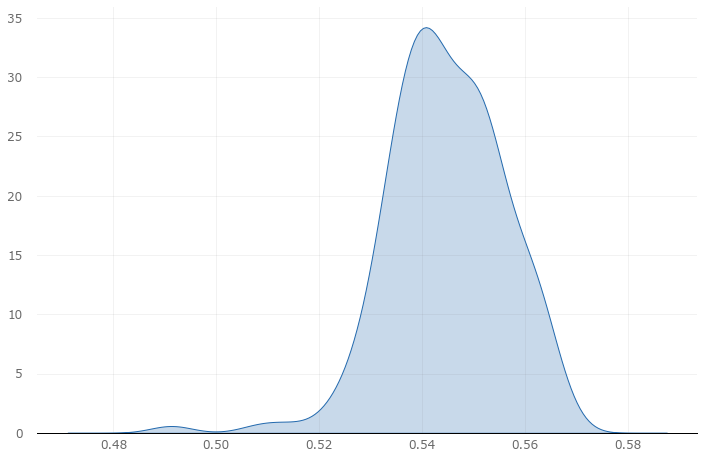

In [48]:
# talos.Analyze(scan).best_params('val_loss',[])
print('accuracy')
talos.Analyze(scan).plot_kde('accuracy')


val_loss


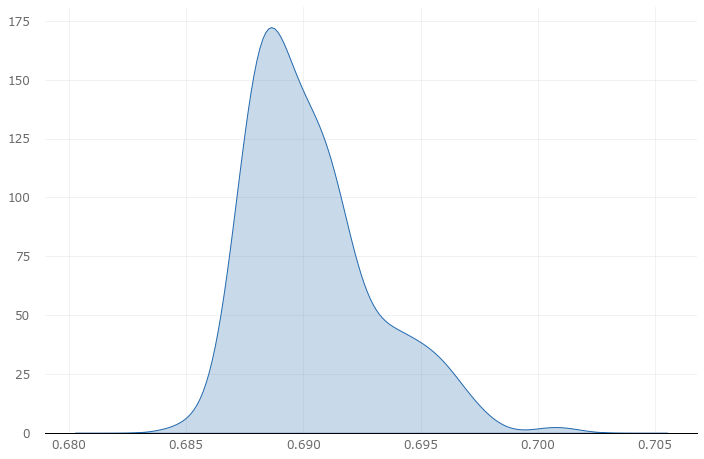

In [49]:
print('val_loss')
talos.Analyze(scan).plot_kde('val_loss')

precision


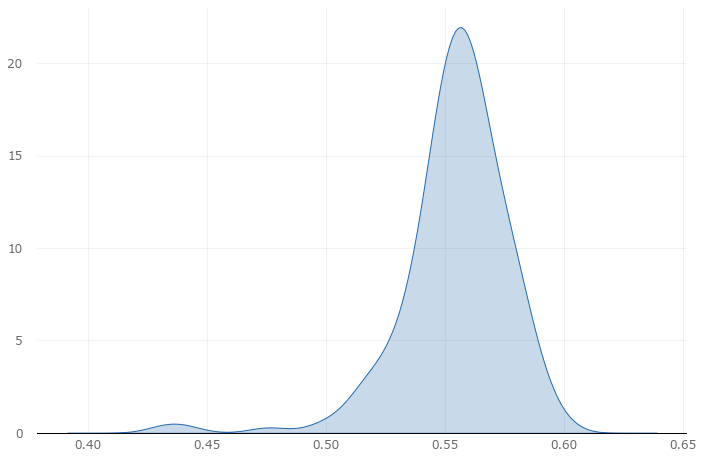

In [50]:
print('precision')
talos.Analyze(scan).plot_kde('precision')


recall


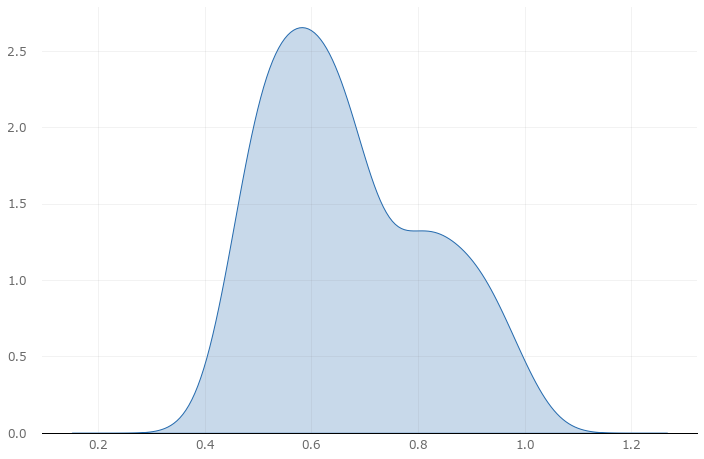

In [51]:
print('recall')
talos.Analyze(scan).plot_kde('recall')


f1


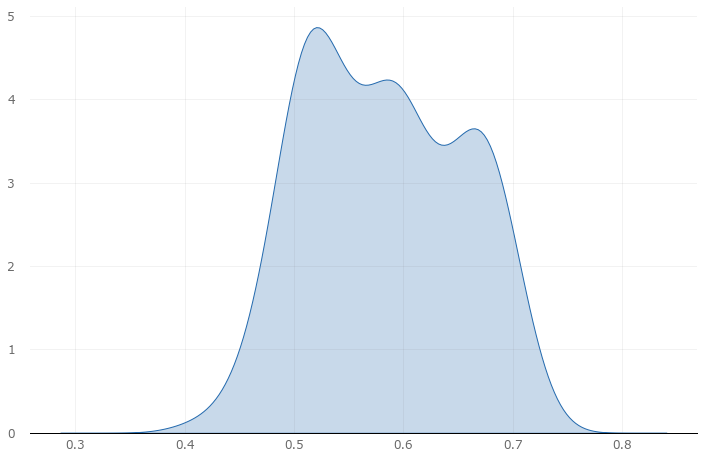

In [52]:
print('f1')
talos.Analyze(scan).plot_kde('f1')

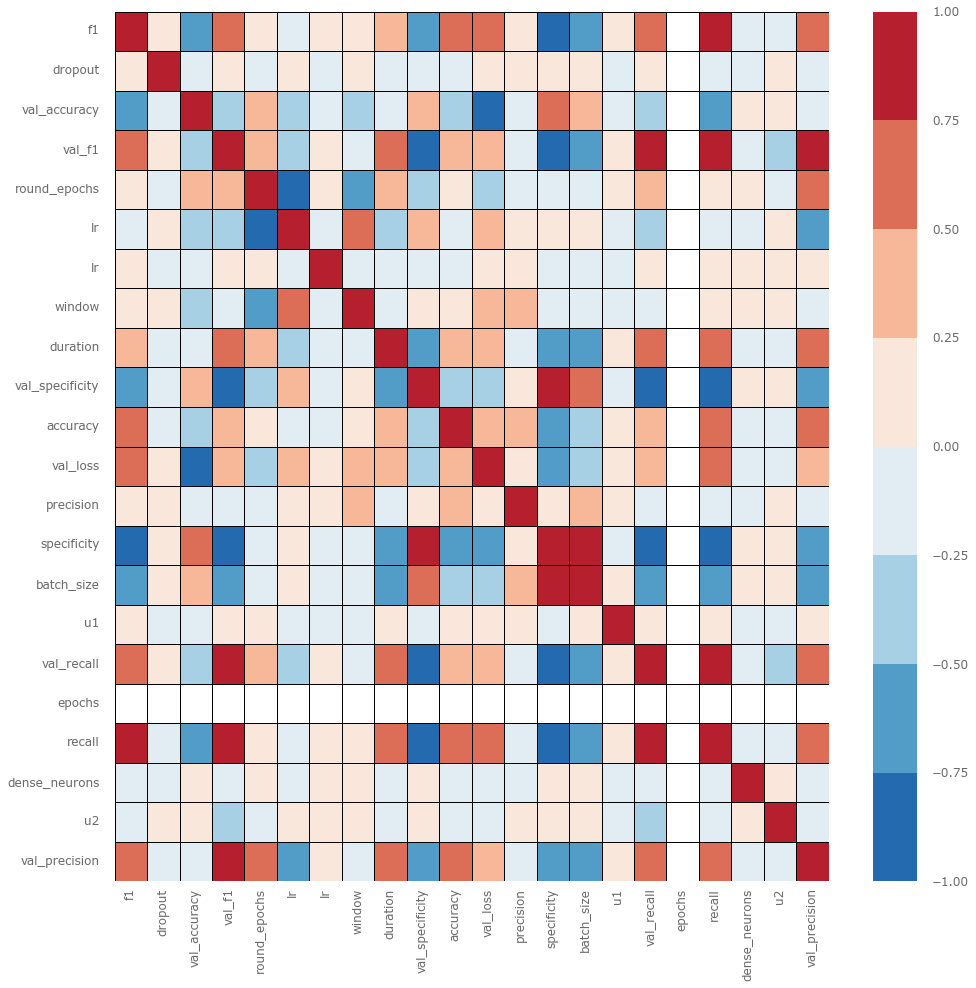

In [54]:
talos.Analyze(scan).plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

None of the hyperparameters seem to correlated significantly with the metrics.
Deploying the best model:

In [59]:
talos.Deploy(scan_object=scan, model_name='classifier', metric='val_loss')

Deploy package classifier have been saved.


In [62]:
classifier = talos.Restore('classifier.zip')

Best configuration:

In [76]:
best = scan.data.sort_values('val_loss').iloc[0][4:]
best

loss               0.691079
accuracy           0.530952
precision          0.513188
recall             0.540726
f1                 0.445406
specificity        0.470488
val_loss           0.685007
val_accuracy       0.566265
val_precision           0.0
val_recall              0.0
val_f1                  0.0
val_specificity         1.0
lr                    0.001
lr                   0.0001
u1                      128
u2                      256
dropout                 0.5
batch_size               32
epochs                  100
optimizer              Adam
activation             relu
dense_neurons            64
window                  200
Name: 53, dtype: object

### Running with best configuration

In [83]:
# best = best.to_dict()
optimal_params = {'lr': best['lr'],
        'u1': best['u1'],
        'u2': best['u2'],
        'dropout': best['dropout'],
        'batch_size': best['batch_size'],
        'epochs': best['epochs'],
        'optimizer': best['optimizer'],
        'activation': best['activation'],
        'dense_neurons': best['dense_neurons'],
        'window': best['window'],
        }

optimal_params

{'lr': 0.0001,
 'u1': 128,
 'u2': 256,
 'dropout': 0.5,
 'batch_size': 32,
 'epochs': 100,
 'optimizer': 'Adam',
 'activation': 'relu',
 'dense_neurons': 64,
 'window': 200}

In [84]:
optimal_params

{'lr': 0.0001,
 'u1': 128,
 'u2': 256,
 'dropout': 0.5,
 'batch_size': 32,
 'epochs': 100,
 'optimizer': 'Adam',
 'activation': 'relu',
 'dense_neurons': 64,
 'window': 200}

In [85]:
tf.keras.backend.clear_session()
#This function defines the LSTM model
win_length = optimal_params['window']
batch_size = optimal_params['batch_size']
num_features= x_train.shape[1]
train_generator = TimeseriesGenerator(scaledtrain, y_train, length= win_length, sampling_rate = 1, batch_size= batch_size)
test_generator = TimeseriesGenerator(scaledtest, y_test, length= win_length, sampling_rate = 1, batch_size= batch_size)
#==================================================================#
# MODEL ARCHITECTURE
model = Sequential()
#Input and first LSTM layer:
model.add(LSTM(units=optimal_params['u1'], input_shape = (win_length, num_features), \
return_sequences=True))
# Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add second layer LSTM
model.add(LSTM(units=optimal_params['u2'], return_sequences=False))
#Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add a Dense layer
model.add(Dense(optimal_params['dense_neurons'], activation = optimal_params['activation']))

#Add the output layer – output layer
model.add(Dense(1, activation = 'sigmoid'))#output layer

#==================================================================#
# Defining Early Stopping to avoid overfitting (after 3 attempts)
early_stopping = EarlyStopping(monitor='val_loss',patience = 30, mode='min', restore_best_weights=True)

# Using exponential decay:

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compiling
# (lr=lr_normalizer(optimal_params['lr'], optimal_params['optimizer']))
# callbacks = [early_stopping, callbacklr],
model.compile(loss='binary_crossentropy', 
                optimizer = optimal_params['optimizer'], 
                metrics=['accuracy',precision,recall,f1,specificity,])

history = model.fit(train_generator,
                    validation_data=test_generator, # validation sample with features
                    epochs = 200, # validation sample with labels
                    shuffle=False, callbacks = [early_stopping, callbacklr],#callbacklr
                    class_weight = class_weight, # imbalanced data
                    verbose=1
                    )

Epoch 1/200
40/40 [==============================] - 8s 144ms/step - loss: 0.6940 - accuracy: 0.5500 - precision: 0.5656 - recall: 0.6827 - f1: 0.5455 - specificity: 0.3278 - val_loss: 0.6842 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/200
40/40 [==============================] - 8s 209ms/step - loss: 0.6914 - accuracy: 0.5548 - precision: 0.4912 - recall: 0.6576 - f1: 0.5192 - specificity: 0.3575 - val_loss: 0.6843 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - 4s 113ms/step - loss: 0.6913 - accuracy: 0.5341 - precision: 0.5091 - recall: 0.6004 - f1: 0.4807 - specificity: 0.3874 - val_loss: 0.6843 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/200
40/4

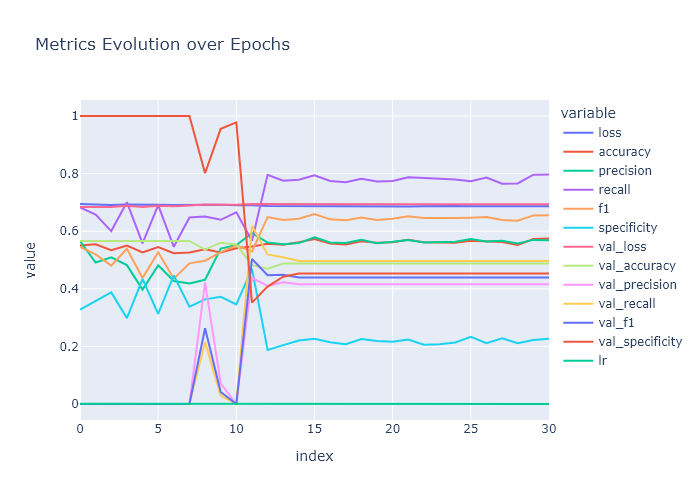

In [88]:
fig = px.line(history.history, title='Metrics Evolution over Epochs')
fig.show('png')

In [92]:
hist_metrics = pd.DataFrame(history.history)
hist_metrics


,loss,accuracy,precision,recall,f1,specificity,val_loss,val_accuracy,val_precision,val_recall,val_f1,val_specificity,lr
0,0.694036,0.550000,0.565627,0.682662,0.545529,0.327777,0.684205,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
1,0.691401,0.554762,0.491204,0.657587,0.519218,0.357468,0.684347,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
2,0.691331,0.534127,0.509109,0.600405,0.480709,0.387368,0.684310,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
3,0.692617,0.550000,0.482136,0.700796,0.539154,0.298112,0.688112,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
4,0.690902,0.526190,0.397130,0.558001,0.437330,0.433941,0.684339,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
5,0.691698,0.545238,0.481374,0.690238,0.526963,0.312892,0.688732,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
6,0.690905,0.523810,0.427169,0.545908,0.434965,0.446294,0.687012,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
7,0.691583,0.526190,0.418562,0.647783,0.488387,0.337738,0.689482,0.566265,0.000000,0.000000,0.000000,1.000000,1.000000e-03
8,0.691038,0.537302,0.431310,0.650719,0.497595,0.363407,0.692545,0.536145,0.421296,0.214929,0.263047,0.801239,1.000000e-03
9,0.691412,0.526190,0.539685,0.639517,0.527284,0.372481,0.691407,0.560241,0.071429,0.029412,0.041667,0.955556,1.000000e-03


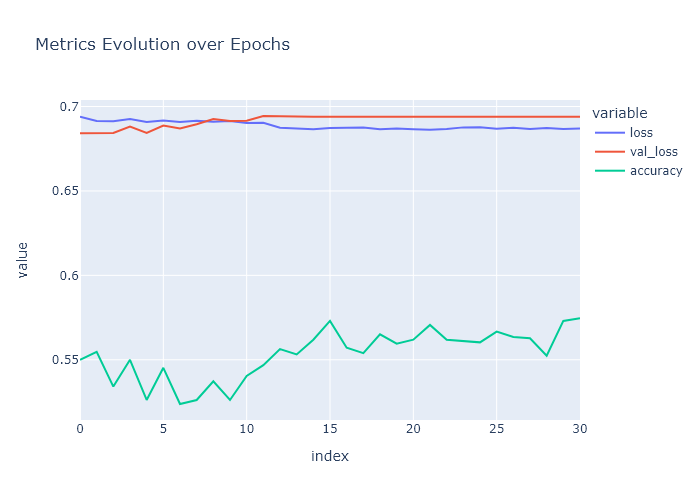

In [95]:
hist_metrics.columns


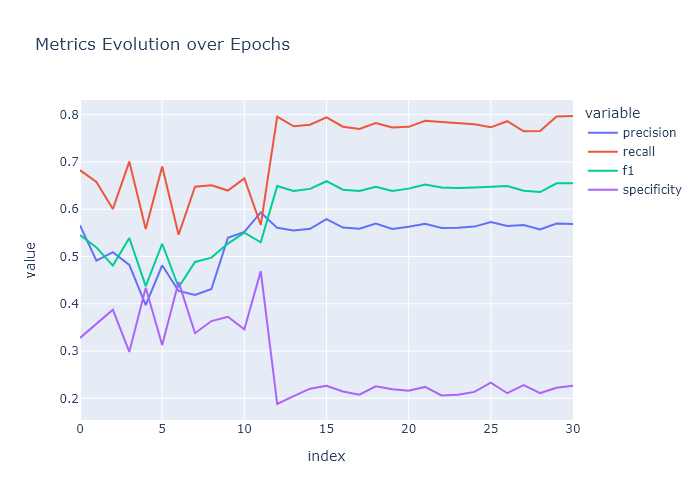

In [96]:
fig = px.line(hist_metrics[['precision','recall','f1','specificity']], title='Metrics Evolution over Epochs')
fig.show('png')

In [168]:
# Predicting
predictions = model.predict(test_generator)
predictions.shape
df_pred = pd.DataFrame(predictions)
df_pred

,0
0,0.400831
1,0.402112
2,0.404463
3,0.407459
4,0.410585
...,...
161,0.434514
162,0.432982
163,0.431150
164,0.429640


In [173]:
final

,target,target_pred
Day,,
2019-07-19,0.0,0
2019-07-20,1.0,0
2019-07-21,0.0,0
2019-07-22,0.0,0
2019-07-23,0.0,0
...,...,...
2019-12-27,1.0,0
2019-12-28,1.0,0
2019-12-29,1.0,0


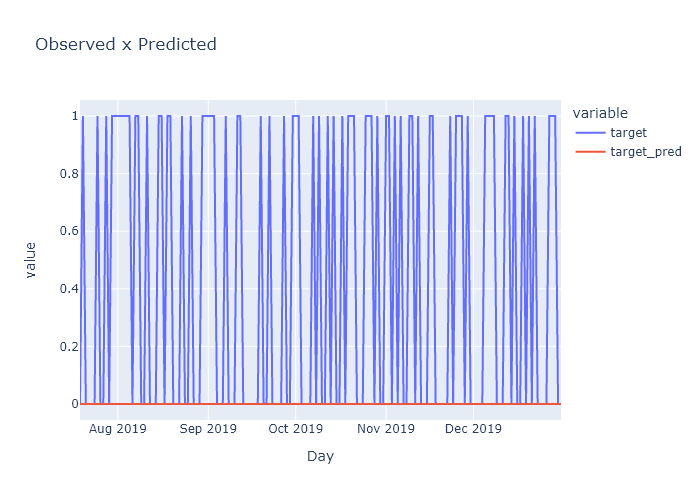

In [172]:
# As the output is a probability
final = df[['target']].iloc[-166:]
final['target_pred']= np.where(df_pred.values>0.5, 0, 0)
fig = px.line(final, title='Observed x Predicted')
fig.show('png')

The model does not convert and therefore the classification fails.

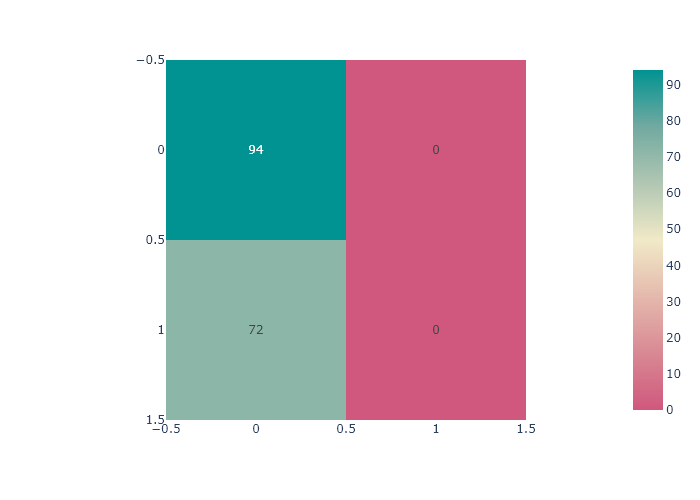

In [181]:
from sklearn.metrics import confusion_matrix

fig = px.imshow(confusion_matrix(final['target'], final['target_pred']), color_continuous_scale='tealrose_r', text_auto=True)
fig.show('png')

In [184]:
# Attempting again with less patience to avoid overfitting
tf.keras.backend.clear_session()
#This function defines the LSTM model
win_length = optimal_params['window']
batch_size = optimal_params['batch_size']
num_features= x_train.shape[1]
train_generator = TimeseriesGenerator(scaledtrain, y_train, length= win_length, sampling_rate = 1, batch_size= batch_size)
test_generator = TimeseriesGenerator(scaledtest, y_test, length= win_length, sampling_rate = 1, batch_size= batch_size)
#==================================================================#
# MODEL ARCHITECTURE
model = Sequential()
#Input and first LSTM layer:
model.add(LSTM(units=optimal_params['u1'], input_shape = (win_length, num_features), \
return_sequences=True))
# Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add second layer LSTM
model.add(LSTM(units=optimal_params['u2'], return_sequences=False))
#Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add a Dense layer
model.add(Dense(optimal_params['dense_neurons'], activation = optimal_params['activation']))

#Add the output layer – output layer
model.add(Dense(1, activation = 'sigmoid'))#output layer

#==================================================================#
# Defining Early Stopping to avoid overfitting (after 3 attempts)
early_stopping = EarlyStopping(monitor='loss',patience = 5, mode='min', restore_best_weights=True)

# Using exponential decay:

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compiling
# (lr=lr_normalizer(optimal_params['lr'], optimal_params['optimizer']))
# callbacks = [early_stopping, callbacklr],
model.compile(loss='binary_crossentropy', 
                optimizer = optimal_params['optimizer'], 
                metrics=['accuracy',precision,recall,f1,specificity,])

history = model.fit(train_generator,
                    validation_data=test_generator, # validation sample with features
                    epochs = 200, # validation sample with labels
                    shuffle=False, callbacks = [early_stopping, ],#callbacklr
                    class_weight = class_weight, # imbalanced data
                    verbose=1
                    )

Epoch 1/200
40/40 [==============================] - 8s 84ms/step - loss: 0.6937 - accuracy: 0.5381 - precision: 0.4908 - recall: 0.6227 - f1: 0.5034 - specificity: 0.3856 - val_loss: 0.6841 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/200
40/40 [==============================] - 2s 51ms/step - loss: 0.6953 - accuracy: 0.5286 - precision: 0.5397 - recall: 0.6289 - f1: 0.5173 - specificity: 0.3676 - val_loss: 0.6871 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/200
40/40 [==============================] - 2s 57ms/step - loss: 0.6916 - accuracy: 0.5222 - precision: 0.4263 - recall: 0.5953 - f1: 0.4623 - specificity: 0.3885 - val_loss: 0.6853 - val_accuracy: 0.5663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/200
40/40 [==============================] - 2s 45

6/6 [==============================] - 1s 47ms/step


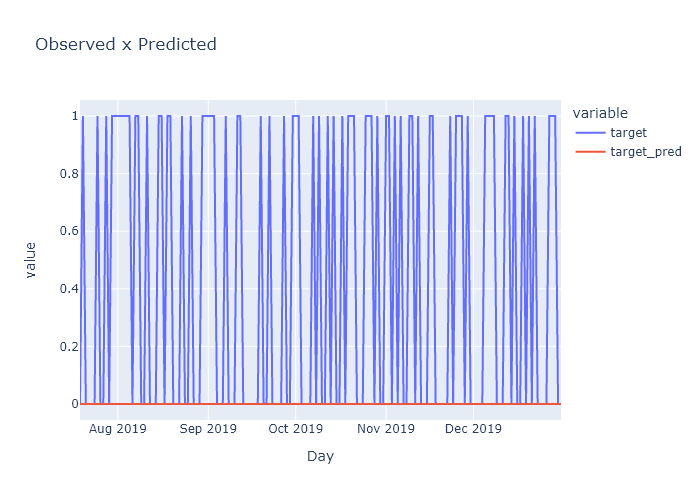

In [185]:
# Predicting
predictions = model.predict(test_generator)
predictions.shape
df_pred = pd.DataFrame(predictions)


# As the output is a probability
final = df[['target']].iloc[-166:]
final['target_pred']= np.where(df_pred.values>0.5, 0, 0)
fig = px.line(final, title='Observed x Predicted')
fig.show('png')